<i>## Comments will be provided using this format. Key takeaway: groups are encouraged to change the formatting, but not the structure. Groups are also allowed to create additional notebooks - for instance, create one notebook for data exploration, and one notebook for each preprocessing-modelling-evaluation pipeline -, but must strive to keep an unified style across notebooks.</i>

#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>

#### Group 11:
- Lourenço Passeiro 20221838
- Miguel Marques 20221839
- Peter Lekszycki 20221840
- Tomás Gonçalves 20221894

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Data Understanding & General Preprocessing](#P1)
- [2. Additional Data Cleaning & Transformations](#P2) 
- [3. Multilabel Classification (Information Requirement 3311)](#P3)
    - [3.1 Specific Data Preparation](#P31)
    - [3.2 Model Implementation](#P32)
    - [3.3 Model Evaluation](#P3n)
- [4. Sentiment Analysis (Information Requirement 3312)](#P4)
    - [4.1 Specific Data Preparation](#P41)
    - [4.2 Model Implementation](#P42)
    - [4.3 Model Evaluation](#P43)

- [5. Co-occurrence Analysis & Clustering (Information Requirements 3321)](#P5)
    - [5.1 Specific Data Preparation](#P51)
    - [5.2 Model Implementation](#P52)
    - [5.3 Model Evaluation](#P53)

- [6. Topic Modelling (Information Requirements 3322)](#P6)
    - [6.1 Specific Data Preparation](#P61)
    - [6.2 Model Implementation](#P62)
    - [6.3 Model Evaluation](#P63)

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from main_pipeline_project import MainPipeline, word_freq_calculator, plot_word_freq,  \
                                    cooccurrence_matrix_generator, cooccurrence_network_generator, fold_score_calculator

# Utils
import os
import glob
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import plotly.express as px
import networkx as nx
# !pip install missingno
import missingno
from wordcloud import WordCloud

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

# Modelling
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

# Clustering & Dimensionality Reduction
from sklearn.cluster import OPTICS, HDBSCAN
from sklearn.decomposition import TruncatedSVD

# Metrics
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error, classification_report, multilabel_confusion_matrix, \
                            silhouette_score, root_mean_squared_error

# Tokenizers
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize

# Distance measures
from rapidfuzz import fuzz

# Sentiment Analyzers
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Pre-trained models
import gensim.downloader
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import spacy

In [2]:
def fetch_data(filename, base_dir = "."):
    """
    Search for a file by name within a given base directory and its subdirectories.

    Args:
        filename (str): The name of the file to search for.
        base_dir (str, optional): The base directory to begin the search. Defaults to the current directory (".").
        
    Returns:
        str or None: The full path of the first matching file if found, otherwise None.
    """
    
    file_pattern = os.path.join(base_dir, '**', filename)
    files_found = glob.glob(file_pattern, recursive=True)
    
    if files_found:
        return files_found[0]
    else:
        return None

In [3]:
reviews_data_path = fetch_data(filename = '10k_reviews.csv')
restaurants_data_path = fetch_data(filename = '105_restaurants.csv')

if reviews_data_path and restaurants_data_path:
    reviews = pd.read_csv(reviews_data_path)
    restaurants = pd.read_csv(restaurants_data_path)
    print('Datasets imported with success')
else:
    print('Sorry could not one or more desired datasets')

Datasets imported with success


<font color='#BFD72F' size=5>1. Data Understanding & General Preprocessing</font> <a class="anchor" id="P1"></a>
  
[Back to TOC](#toc)

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [5]:
reviews.sample(5)

Restaurant            Reviewer  \
8313                      GD's      Almas Khorrami   
9344  Zing's Northeast Kitchen      Saran Raparthy   
7881                Khaan Saab         Aamir Nawaz   
8642        The Chocolate Room  The Fit Foodie 😋😎🤑   
4565               Owm Nom Nom      Pagoti Appanna   

                                                 Review Rating  \
8313  Tried the Mercury burger 🍔 It is cheesy burger...      4   
9344  Had been there today with the reviews seen her...      1   
7881  Dishes Tried: Lal Mirch Tikka, Tundey Kebab, R...      3   
8642  Superb place. Went to fulfill some early morni...      5   
4565                                                  4      3   

                        Metadata             Time  Pictures  
8313    2 Reviews , 17 Followers  2/18/2019 16:12         1  
9344   14 Reviews , 66 Followers  1/27/2019 16:41         0  
7881   42 Reviews , 58 Followers    2/4/2019 9:02         4  
8642  26 Reviews , 330 Followers   9/3/2018 20:49         5  
4565                   2 Reviews  7/28/2018 14:02         0

In [6]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.1+ KB


In [7]:
restaurants.sample(5)

Name  \
104  Republic Of Noodles - Lemon Tree Hotel   
97          Zega - Sheraton Hyderabad Hotel   
35                Green Bawarchi Restaurant   
9                               Cream Stone   
7                  Shah Ghouse Spl Shawarma   

                                                 Links   Cost  \
104  https://www.zomato.com/hyderabad/republic-of-n...  1,700   
97   https://www.zomato.com/hyderabad/zega-sheraton...  1,750   
35   https://www.zomato.com/hyderabad/green-bawarch...    700   
9    https://www.zomato.com/hyderabad/cream-stone-g...    350   
7    https://www.zomato.com/hyderabad/shah-ghouse-s...    300   

              Collections                         Cuisines  \
104  Pan-Asian Delicacies  Thai, Asian, Chinese, Malaysian   
97                    NaN                     Asian, Sushi   
35                    NaN   North Indian, Chinese, Biryani   
9         Frozen Delights              Ice Cream, Desserts   
7                     NaN                         Lebanese   

                                               Timings  
104              11:30 AM to 3 PM, 7 PM to 12 Midnight  
97                             12Noon to 2AM (Mon-Sun)  
35                                    12 Noon to 11 PM  
9    10 AM to 1 AM (Mon-Thu), 10 AM to 1:30 AM (Fri...  
7                               12 Noon to 12 Midnight

### General Preprocessing
In order to truly understand our data, first we have to perform a general preprocessing of our data, in way that the datasets are workable and processable.

On the reviews' dataset:
- Cleaned one record that had a 'Rating' of 'Like', instead of a number 0-5;
- Updated the 'Time' variable datatype to datetime and 'Rating' to numerical;
- Excluded every record with missing values (only 0.5% of them), as none of them had the review text, the main element to answer the IRs.

On the restaurants' dataset:
- Cleaned the 'Cost' variable, and set its datatype to numerical;
- Created a 'Score' variable to store the average rating of each restaurant;
- Transformed the 'Cuisines' variable, with each restaurant having a list of their cuisines, in a more processable way (lower case and without spaces).

In [8]:
reviews['Rating'].value_counts()

Rating
5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: count, dtype: int64

In [9]:
# Let's check the review text to see what rating should we replace it with.
reviews.loc[ reviews.Rating == 'Like' ].Review.values[0]

'One of the best pizzas to try. It served with the fresh crust and the topping of veggies are fresh and the taste of the ingredients was awesome and it is fully overloaded with Cheese. I would like to recommend to try every Time I wager for pizza'

In [10]:
# Given this review, we think it is fair to assign a 5* rating (since it is also the most common rating, we are not making a stretch).
reviews.loc[ reviews.loc[ reviews.Rating == 'Like' ].index , 'Rating'] = '5' 

In [11]:
# Updating the datatypes to the best & lighter option
reviews = reviews.astype({
    'Rating': 'float16'})

reviews['Time'] = pd.to_datetime(reviews['Time'], format='%m/%d/%Y %H:%M')

In [12]:
# Checking the % of missing values of each feature
reviews.isnull().sum() / len(reviews)

Restaurant    0.0000
Reviewer      0.0038
Review        0.0045
Rating        0.0038
Metadata      0.0038
Time          0.0038
Pictures      0.0000
dtype: float64

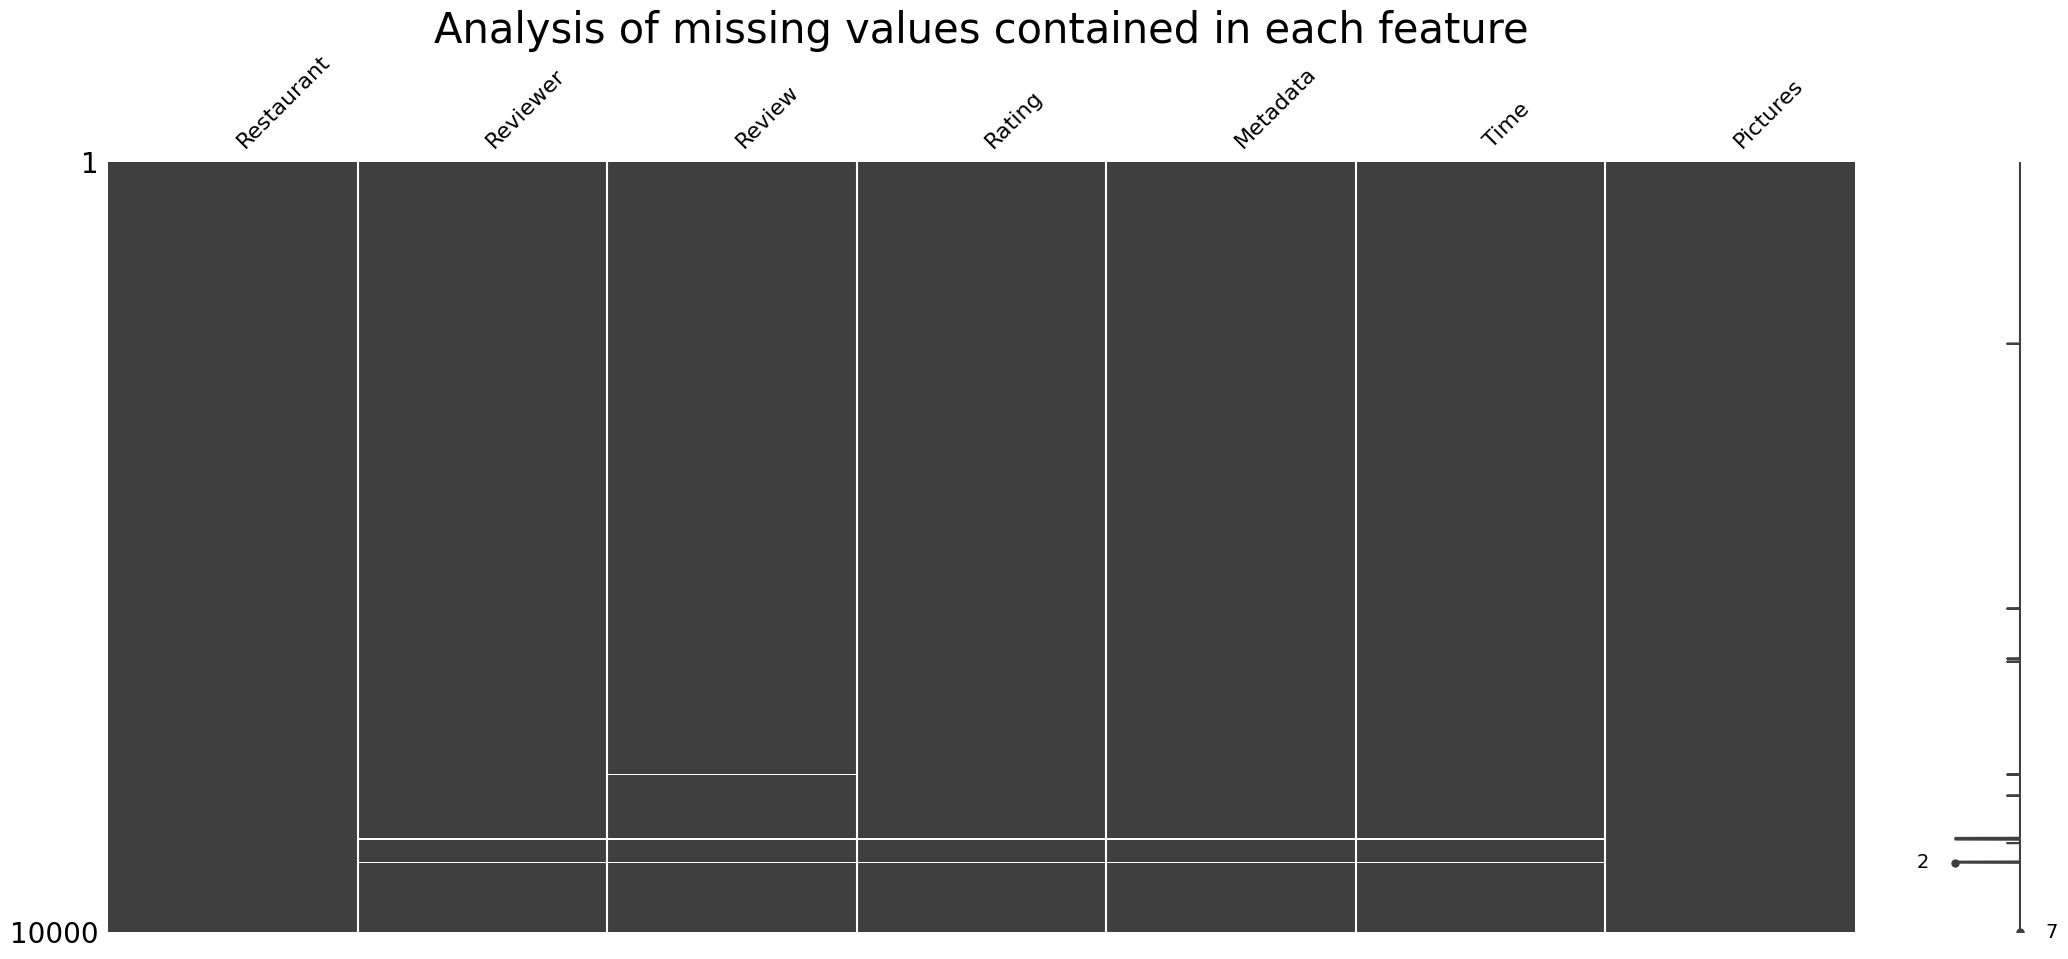

In [13]:
missingno.matrix(reviews)
plt.title("Analysis of missing values contained in each feature", fontsize=30)
plt.show()

Since every row with missing values has no review text, we will exclude them, given that our entire work revolves around the text part of reviews.

In [14]:
# Dropping the rows with missing values
reviews = reviews.drop(reviews.loc[reviews.isnull().any(axis=1), :].index)

In [15]:
# Removing the restaurant that were left without reviews from the restaurant dataset
restaurants = restaurants.drop(restaurants.loc[~restaurants.Name.isin(reviews.Restaurant)].index)

In [16]:
# Every value with 4 digits has a comma in it
restaurants.Cost[:5]

0      800
1      800
2    1,300
3      800
4    1,200
Name: Cost, dtype: object

In [17]:
# Replacing every restaurant's cost with a comma with an empty space
restaurants.Cost = restaurants.Cost.str.replace(',','')

# Setting the datatype to the lighter possible option
restaurants.Cost = restaurants.Cost.astype('int16')

Creating the score variable:

In [18]:
# Sorting both datasets by restaurant name
restaurants.sort_values('Name', inplace=True)
reviews.sort_values('Restaurant', inplace=True)

# Creating the score variable
restaurants['Score'] = reviews.groupby('Restaurant')['Rating'].mean().values
restaurants['Score'] = round(restaurants['Score'], 4)

Transforming the Cuisine variable in a easier to process way:

In [19]:
restaurants.Cuisines = restaurants.Cuisines.apply(lambda x: x.lower().replace(" ","").split(","))

### Data Understanding:
Main Insights:
- Reviews’ and restaurants’ ratings follow very different distributions, with a left-skewed and a close-to-normal distribution, respectively. Nonetheless, the average rating of both reviews and restaurants is 3.6 stars;
- The normal price of a meal is around 700 rupees;
- Although the reviews date from 2016, the majority come after the second half of 2018;
- Restaurants' meal costs and average rating are moderately correlated;
- The most frequent cuisines are North Indian and Chinese, that have an average rating;
- All the most expensive cuisines tend to have close to average ratings, except Mediterranean, that is the best rated cuisine by far;
- The reviews' word cloud tells us that there is an overall positive sentiment in the reviews, and food itself is not the only decisive factor on reviews, with words like "ambience", "service", and "staff" being very frequent.


In [20]:
reviews.describe(include='all')

Restaurant Reviewer Review       Rating  Metadata  \
count                9955     9955   9955  9955.000000      9955   
unique                100     7442   9364          NaN      2477   
top     10 Downing Street   Ankita   good          NaN  1 Review   
freq                  100       13    237          NaN       916   
mean                  NaN      NaN    NaN     3.601562       NaN   
min                   NaN      NaN    NaN     1.000000       NaN   
25%                   NaN      NaN    NaN     3.000000       NaN   
50%                   NaN      NaN    NaN     4.000000       NaN   
75%                   NaN      NaN    NaN     5.000000       NaN   
max                   NaN      NaN    NaN     5.000000       NaN   
std                   NaN      NaN    NaN     1.483398       NaN   

                                 Time     Pictures  
count                            9955  9955.000000  
unique                            NaN          NaN  
top                               NaN          NaN  
freq                              NaN          NaN  
mean    2018-11-29 12:33:09.088899840     0.751984  
min               2016-05-31 16:41:00     0.000000  
25%               2018-08-12 00:10:30     0.000000  
50%               2018-12-24 00:13:00     0.000000  
75%               2019-03-31 20:10:00     0.000000  
max               2019-05-25 20:23:00    64.000000  
std                               NaN     2.575691

In [21]:
restaurants.describe(include='all')

Name                                              Links  \
count                 100                                                100   
unique                100                                                100   
top     10 Downing Street  https://www.zomato.com/hyderabad/10-downing-st...   
freq                    1                                                  1   
mean                  NaN                                                NaN   
std                   NaN                                                NaN   
min                   NaN                                                NaN   
25%                   NaN                                                NaN   
50%                   NaN                                                NaN   
75%                   NaN                                                NaN   
max                   NaN                                                NaN   

               Cost                                  Collections  \
count    100.000000                                           50   
unique          NaN                                           42   
top             NaN  Food Hygiene Rated Restaurants in Hyderabad   
freq            NaN                                            4   
mean     872.000000                                          NaN   
std      505.940468                                          NaN   
min      150.000000                                          NaN   
25%      500.000000                                          NaN   
50%      700.000000                                          NaN   
75%     1200.000000                                          NaN   
max     2800.000000                                          NaN   

                      Cuisines                 Timings       Score  
count                      100                      99  100.000000  
unique                      89                      74         NaN  
top     [northindian, chinese]  12 Noon to 12 Midnight         NaN  
freq                         4                       5         NaN  
mean                       NaN                     NaN    3.602029  
std                        NaN                     NaN    0.508105  
min                        NaN                     NaN    2.400000  
25%                        NaN                     NaN    3.245000  
50%                        NaN                     NaN    3.615000  
75%                        NaN                     NaN    3.846250  
max                        NaN                     NaN    4.880000

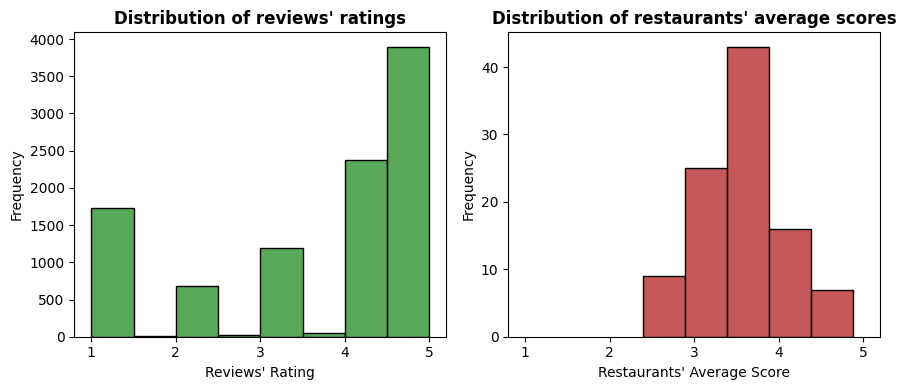

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True)

sns.histplot(reviews.Rating, binwidth=0.5, color='forestgreen', ax=ax[0])
ax[0].set_title("Distribution of reviews' ratings", fontsize=12, fontweight='bold')
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Reviews' Rating")

sns.histplot(restaurants.Score, binwidth=0.5, color='firebrick', ax=ax[1])
ax[1].set_title("Distribution of restaurants' average scores", fontsize=12, fontweight='bold')
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("Restaurants' Average Score")

plt.tight_layout()
plt.show()

**Reviews' Ratings:**
- Left-skewed distribution: As seen before, there is a clear bias toward higher ratings. This may tell us that people are more likely to leave reviews when they have a very positive experience (or when nothing goes wrong), leading to more 4 and 5-star ratings.

**Restaurants' Average Scores:**
- Balanced distribution: The restaurant averages show a more centered distribution, with fewer restaurants achieving extremely low or high averages. Since the average score is calculated across many reviews, it tends to smooth out individual extremes and give a more balanced view of overall quality.


Nonetheless, both reviews' and restaurants' average score is 3.6.

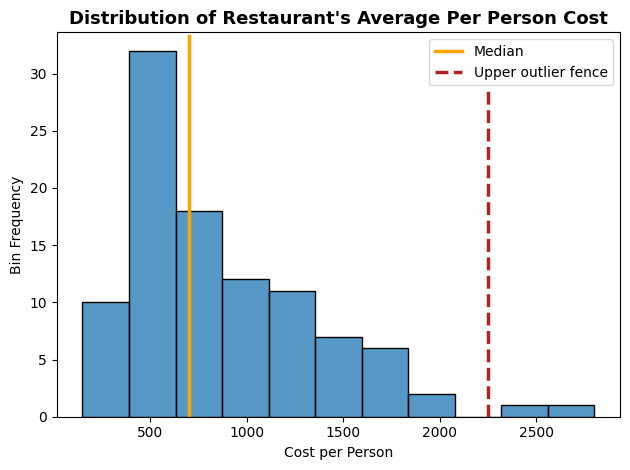

In [23]:
iqr = restaurants.Cost.quantile(.75) - restaurants.Cost.quantile(.25)

sns.histplot(restaurants.Cost, binwidth=250)

plt.axvline(restaurants.Cost.median(), color='orange', linewidth=2.5, ymax=0.99)
plt.axvline(restaurants.Cost.quantile(.75) + 1.5*iqr, ymin=0, ymax=.85, color='firebrick', linewidth=2.5, linestyle='--')

plt.title("Distribution of Restaurant's Average Per Person Cost", fontsize=13, fontweight='bold')
plt.xlabel("Cost per Person")
plt.ylabel("Bin Frequency")

plt.legend(['Median', 'Upper outlier fence'])
plt.tight_layout()
plt.show()

The normal per person cost of a meal in our restaurants is around 700 rupees. There are two restaurants with a cost over 2500 rupees (clear outliers). Surprisingly, one of them has a pretty average score.

In [24]:
restaurants.loc[ restaurants.Cost > 2200 ]

Name  \
92  Collage - Hyatt Hyderabad Gachibowli   
56      Feast - Sheraton Hyderabad Hotel   

                                                Links  Cost  \
92  https://www.zomato.com/hyderabad/collage-hyatt...  2800   
56  https://www.zomato.com/hyderabad/feast-sherato...  2500   

                                          Collections  \
92                                    Sunday Brunches   
56  Sunday Brunches, Great Breakfasts, Function Ve...   

                                             Cuisines  \
92  [continental, italian, northindian, chinese, a...   
56        [modernindian, asian, continental, italian]   

                                              Timings  Score  
92                                 24 Hours (Mon-Sun)   3.41  
56  6:30am to 10:30am, 12:30pm to 3pm, 7pm to 11pm...   4.22

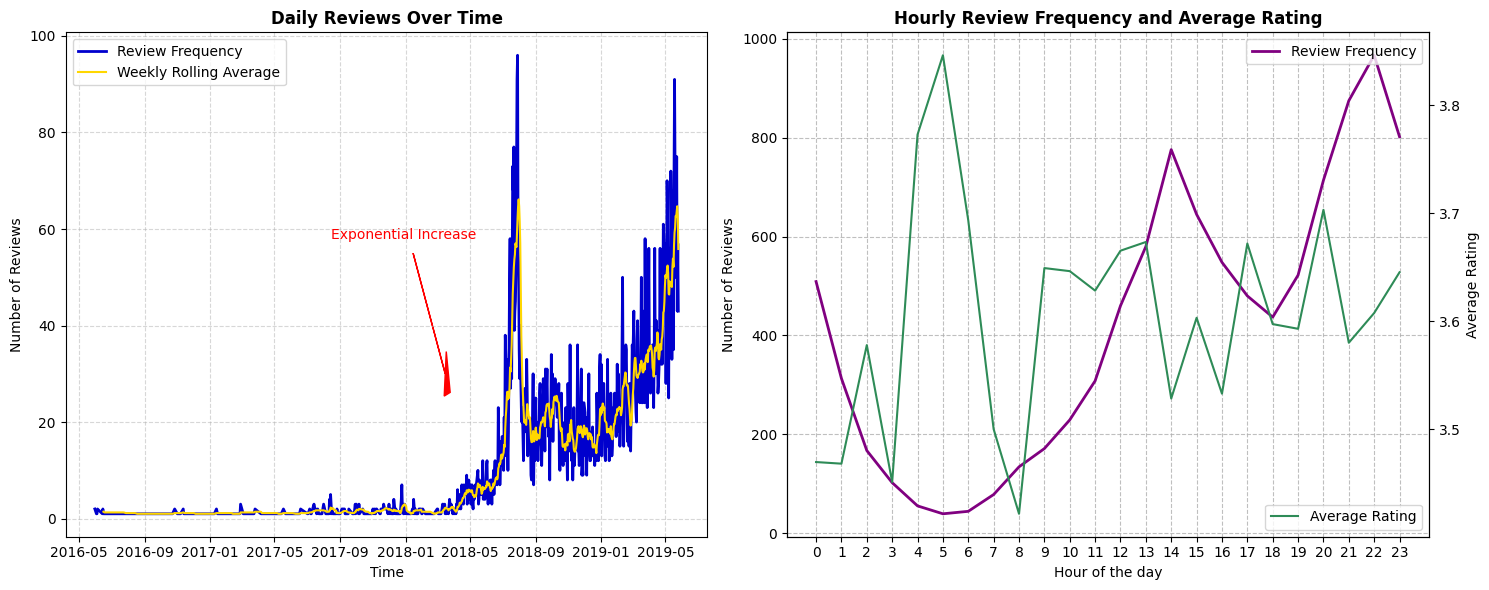

In [25]:
daily_reviews = reviews.groupby(reviews.Time.dt.date).size()
hourly_reviews = reviews.groupby(reviews.Time.dt.hour).size()
average_hourly_ratings = reviews.groupby(reviews.Time.dt.hour)['Rating'].mean()

fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].plot(daily_reviews.index, daily_reviews.values, color='mediumblue', linewidth=2, label='Review Frequency')

ax[0].set_title('Daily Reviews Over Time', fontweight='bold')
ax[0].set_xlabel('Time', fontsize=10)
ax[0].set_ylabel('Number of Reviews')
ax[0].grid(True, linestyle='--', alpha=0.5)

ax[0].arrow(pd.Timestamp('2018-01-15'), 55, 60, -25, head_width=10, head_length=10, ec='red', fc='red')
ax[0].text(pd.Timestamp('2017-08-15'), 58, 'Exponential Increase', c='red')

daily_counts_rolling = daily_reviews.rolling(window=7).mean()  
ax[0].plot(daily_reviews.index, daily_counts_rolling, color='gold', linestyle='-', label='Weekly Rolling Average')
ax[0].legend()

ax[1].plot(hourly_reviews.index, hourly_reviews.values, color='purple', linewidth=2, label='Review Frequency')
ax1 = ax[1].twinx()
ax1.plot(average_hourly_ratings.index, average_hourly_ratings.values, color='seagreen', label='Average Rating')
ax1.set_ylabel('Average Rating')
ax1.legend(loc=4)

ax[1].set_title('Hourly Review Frequency and Average Rating', fontweight='bold')
ax[1].set_xlabel('Hour of the day', fontsize=10)
ax[1].set_ylabel('Number of Reviews')
ax[1].set_xticks(ticks=range(0,24))
ax[1].grid(True, linestyle='--', alpha=0.8)
ax[1].legend(loc=1)

plt.tight_layout()
plt.show()

- Even though the reviews date from 2016-2019, the huge majority of them are from 2018-2019, as there is a exponential increase on the end of 2018;
- The hourly number of reviews seems to be understandable, as the frequency increases as the day goes until night, where falls again;
- The hourly average rating does not seem to be strongly correlated with the hourly frequency. However, it peaks at hour 5, where frequency reachs its lowest point (only very happy people perform reviews at such an hour :) ). It is also worth noting that sometimes when the frequency increases (hour 14, 21), the ratings goes down, what may be a consequence of the increase of the number of samples.

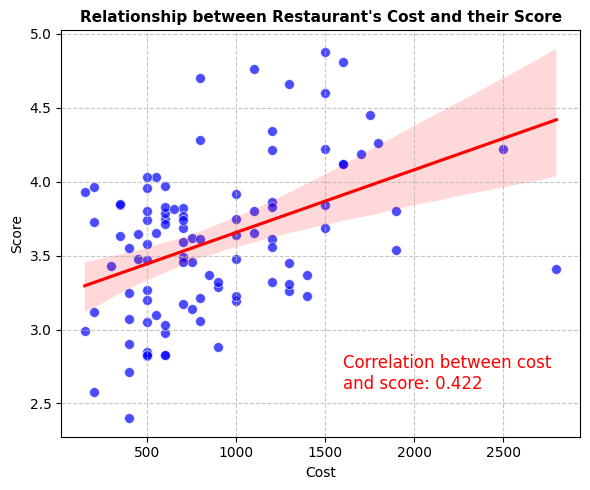

In [26]:
cost = restaurants.Cost
rating = restaurants.Score

plt.figure(figsize=(6, 5))

sns.scatterplot(x=cost, y=rating, color='blue', s=50, alpha=0.7)
sns.regplot(x=cost, y=rating, scatter=False, color='red', ci=95)

plt.title("Relationship between Restaurant's Cost and their Score", fontsize=11, fontweight='bold')
plt.xlabel("Cost", fontsize=10)
plt.ylabel("Score", fontsize=10)
#plt.xlim(0, 2000) # Removing outliers
plt.grid(True, linestyle='--', alpha=0.7)

correlation_value = np.corrcoef(cost, rating)[0, 1] 
plt.text(1600, 2.6, f'Correlation between cost\nand score: {round(correlation_value, 3)}', fontsize=12, color='red')

plt.tight_layout()
plt.show()


As expected, there  is a moderate positive correlation between the cost and score of a restaurant.

**Cuisine analysis:**

Firstly, we have to extract all the possible cuisine types (the labels), and also the frequency of each different cuisine:

In [27]:
# Iterating over every restaurant, extracting their cuisine combinations, and extract every cuisine there
cuisines = [cuisine for cuisines_lt in restaurants.Cuisines for cuisine in cuisines_lt]

# Creating a dictionary to store the cuisine names (keys) and their frequencies (values)
cuisines_freq = dict(Counter(cuisines))

# Getting only the unique cuisines
cuisines = np.unique(cuisines)

Now, we extracted the average rating and cost of each type of cuisine. To facilitate implementations we passed our frequencies to a dataframe.

In [28]:
exploded_restaurants = restaurants.explode('Cuisines')

# Calculate the frequency, average score, and average cost for each cuisine
cuisine_data = exploded_restaurants.groupby('Cuisines').agg(
                                                            Frequency=('Cuisines', 'size'),
                                                            Score=('Score', 'mean'),
                                                            Cost=('Cost', 'mean')
                                                            ).round(3).sort_values('Frequency', ascending=False)

cuisine_data = pd.DataFrame(cuisine_data)
cuisine_data.head()

Frequency  Score      Cost
Cuisines                               
northindian         60  3.597   963.333
chinese             41  3.464   885.366
continental         21  3.819  1307.143
biryani             15  3.383   660.000
italian             14  3.776  1532.143

In [29]:
# Custom color palette to have enough different colors in the plot
custom_palette = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf','#9edae5','#f7b6d2',
                     '#c5b0d5','#c49c94','#f6eb61','#e377c2','#ff9896', '#c7c7c7','#dbdb8d','#ffbb78','#c0e2ff','#ffcccb','#c3e2f5','#ffcc00',
                     '#d6c9e0','#b5e48c','#f9b5d9']

plot_data = cuisine_data.loc[cuisine_data.Frequency > 3].reset_index(names='Cuisine')

fig = px.scatter(
    plot_data,
    x='Cost',
    y='Score',
    size='Frequency',          
    color='Cuisine',    
    hover_name='Cuisine',
    size_max=50,           
    color_discrete_sequence=custom_palette,
    trendline='ols'
)

fig.update_layout(
    title="Bubble Plot of Cuisine Frequency vs Rating vs Cost",
    xaxis_title="Average Cost",
    yaxis_title="Average Rating",
    legend_title="Cuisine Type",
    legend=dict(
        x=1.05, y=1,          
        bordercolor='black', 
        borderwidth=1 ),
    annotations=[
        dict(
            x=1.21, y=1.1, xref="paper", yref="paper",
            text="Bubble Size = Frequency",
            showarrow=False,
            font=dict(size=15)
        )]
)

fig.show()

- Cuisine ratings and costs seem to be positively correlated;
- The most frequent cuisines, North Indian and Chinese, have an average rating;
- Sushi, Italian, Asian, and Continental are the most expensive cuisines, but their ratings are not far from average. Mediterranean cuisine follows the opposite path, as it is the 4th more expensive cuisine and is the best rated, by far;
- Fast Food and Burger cuisines are the worst rated, but also the cheapest (no surprise).

Producing a word cloud of every word in our data:

In [30]:
bow_vectorizer_all = CountVectorizer()
preprocessor = MainPipeline(tokenized_output=True)

all_words = [ word for review in reviews.Review for word in preprocessor.main_pipeline(raw_text=review) ]
word_matrix = bow_vectorizer_all.fit_transform(all_words).toarray()
words = bow_vectorizer_all.get_feature_names_out()

In [31]:
def word_cloud_generator(folder_path, wc, word_matrix=word_matrix, words=words, title='all'):

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    bow_df = word_freq_calculator(word_matrix, words)
    bow_dict = bow_df.set_index('words')['frequency'].to_dict()
    wc.generate_from_frequencies(bow_dict) 
    wc.to_file(os.path.join(folder_path, "WC_"+title+".png"))

In [32]:
wc = WordCloud(background_color="white",max_words=110, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))
word_cloud_generator('word_clouds', wc)

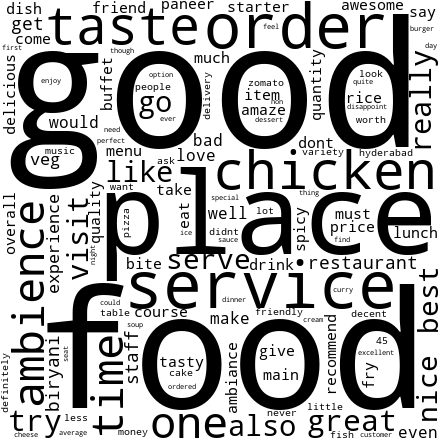

- **Overall positive sentiment:** most of the frequent words (mainly adjectives and adverbs) are positive. This makes sense given the distribution of the reviews' ratings;

- **Popular dishes are noticeable:** words like "chicken", "biryani", "paneer", and "rice" imply that these dishes are either recommended or commonly ordered by customers.

- **Experience and atmosphere:** the presence of words like "ambience", "service", "experience", "staff" highlights that the food itself is not the only decisive factor on a review;

- As expected, words like "food", "try", "taste" and "order" are one of the most frequent, since they are always in reviews independently of their sentiment;


Generating word clouds for every cuisine:

In [33]:
restaurants_wc_data = restaurants.drop(['Links', 'Cost', 'Collections', 'Timings', 'Score'],axis = 1)
reviews_wc_data = reviews.drop(['Reviewer', 'Rating', 'Metadata', 'Time', 'Pictures'], axis = 1)
reviews_wc_data = pd.merge(reviews_wc_data, restaurants_wc_data[['Name', 'Cuisines']], left_on='Restaurant', right_on='Name', how='left')
reviews_wc_data = reviews_wc_data.drop(columns=['Name'])
reviews_wc_data.head(3)

Restaurant                                             Review  \
0  10 Downing Street  Went with Collegues for lunch...Good Food.. .....   
1  10 Downing Street  Great place and a really amazing crowd. The am...   
2  10 Downing Street  A grand entry, decent ambience and average foo...   

                              Cuisines  
0  [northindian, chinese, continental]  
1  [northindian, chinese, continental]  
2  [northindian, chinese, continental]

In [34]:
reviews_wc_data.drop(['Restaurant'], axis = 1, inplace = True)
reviews_wc_data = reviews_wc_data[['Cuisines', 'Review']]
reviews_wc_data.head(3)

Cuisines  \
0  [northindian, chinese, continental]   
1  [northindian, chinese, continental]   
2  [northindian, chinese, continental]   

                                              Review  
0  Went with Collegues for lunch...Good Food.. .....  
1  Great place and a really amazing crowd. The am...  
2  A grand entry, decent ambience and average foo...

In [35]:
reviews_wc_data = reviews_wc_data.explode('Cuisines')
reviews_wc_data = reviews_wc_data.groupby('Cuisines')['Review'].apply(lambda x: ' '.join(x)).reset_index()
reviews_wc_data.head(3)

Cuisines                                             Review
0  american  Good sizzler taste. Portion size may be too mu...
1    andhra  Have visited this place with colleagues for te...
2   arabian  Ordered mutton Biryani after reading good revi...

In [37]:
for cuisine, review in reviews_wc_data[['Cuisines', 'Review']].values:
    all_words_cuisine = [word for word in preprocessor.main_pipeline(raw_text=review) if word not in ['good', 'place', 'food', 'chicken', 'order', 'really', 'get',
                                                                                              'great', 'service', 'visit', 'taste', 'serve', 'one', 'dish',
                                                                                              'item', 'also', 'ambience', 'time', 'restaurant', 'try', 'go']]
    word_matrix_cuisine = bow_vectorizer_all.fit_transform(all_words_cuisine).toarray()
    words_cuisine = bow_vectorizer_all.get_feature_names_out()
    wc_cuisine = WordCloud(background_color="white",max_words=80, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))
    word_cloud_generator('word_clouds', wc, word_matrix=word_matrix_cuisine, words=words_cuisine, title = cuisine)

| **North Indian Word Cloud** | **South Indian Word Cloud** |
|-----------------------------|-----------------------------|
| 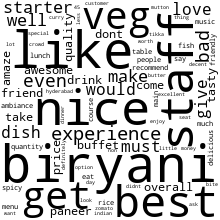 | 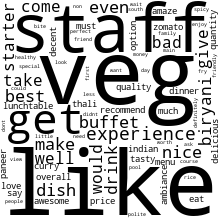 |

- The Indian cuisines do not differ much;
- Biryani and Paneer dishes seem to be more common on North Indian cuisine;
- South Indian cuisine seems to have a more vegetarian-focused cuisine.

### <font color='#BFD72F' size=5>2. Additional Data Cleaning & Transformations</font> <a class="anchor" id="P2"></a>
  
[Back to TOC](#toc)

In this section we performed the necessary operations that were not mandatory to be made earlier in order to understand our data better.

On the reviews dataset:
- Updated the column data types
- Converted the 'Metadata' feature into two different features containing the reviews ('Metadata_Reviews') and followers ('Metadata_Follows'), in order to make that data easier to work.

In [38]:
# Setting the datatypes to the lighter possible option
reviews = reviews.astype({'Pictures': 'int8'})

In [39]:
# Splitting 'Metadata' into two, by splitting by the comma
reviews[['Metadata_Reviews', 'Metadata_Follows']] = reviews['Metadata'].str.split(' , ', expand=True)
# Dropping the 'Metadata' feature (not useful anymore)
reviews = reviews.drop('Metadata', axis=1)

# Keeping only the digits from reviews, using a regex expression
reviews['Metadata_Reviews'] = reviews['Metadata_Reviews'].str.extract(r'(\d+)').astype('int16')

# Some reviewers did not have followers (Had NaN values). We imputed zeros in this case, to avoid NaN erros
reviews['Metadata_Follows'] = reviews['Metadata_Follows'].fillna('0')

# Keeping only the digits from followers, using a regex expression
reviews['Metadata_Follows'] = reviews['Metadata_Follows'].str.extract(r'(\d+)').astype('int16')

In [40]:
reviews.sample(5)

Restaurant                      Reviewer  \
7231                     Labonel                   Jenson Jose   
3281        Marsala Food Company  Chaithanya Guptha Gollapalli   
2588                  Tiki Shack                      Mohan Kr   
4362  The Foodie Monster Kitchen                         Vinay   
8449                     T Grill                     Trishna M   

                                                 Review  Rating  \
7231  An Al time favorite..ordered classic chocolate...     5.0   
3281  Soups: Had tomato soup and sweet corn veg soup...     4.0   
2588  Lovely place, a delight everytime i walkin. Be...     5.0   
4362  Located in such a place where numerous food co...     3.0   
8449  Ordered a nice dinner for two from T Grill. Th...     3.0   

                    Time  Pictures  Metadata_Reviews  Metadata_Follows  
7231 2018-07-04 11:52:00         0                 1                 6  
3281 2019-02-28 23:07:00         6                85               779  
2588 2019-02-21 23:13:00         0                10                 4  
4362 2018-08-10 07:55:00         1               111               450  
8449 2018-07-08 16:16:00         2               316              1156

There are 7442 reviewers

In [41]:
# 7442 different customers
reviews.Reviewer.nunique()

7442

On the restaurants dataset:
- Dropped the 'Link' variable, as it will not aide our work in any way;
- Acknowledged the fact that half the restaurants are not assigned to any collection, as it is not important enough to consider remove them;
- At the end, we integrated the reviews dataset here.

In [42]:
# Dropping the links feature
restaurants = restaurants.drop(['Links', 'Collections', 'Timings'], axis=1)

In [43]:
# Checking the % of missing values of each feature
restaurants.isnull().sum() / len(restaurants)

Name        0.0
Cost        0.0
Cuisines    0.0
Score       0.0
dtype: float64

We decided to integrate the reviews on the restaurant dataset, as the tasks are restaurant-focused.

In [44]:
aggregated_reviews = reviews.groupby('Restaurant').agg({
    'Reviewer': list,
    'Review': list,
    'Rating': list,
    'Pictures': list,
    'Metadata_Reviews': list,
    'Metadata_Follows': list,
    'Time': list
}).reset_index()

In [45]:
data = aggregated_reviews.set_index("Restaurant").join(restaurants.set_index("Name")).reset_index()
data.head()

Restaurant  \
0               10 Downing Street   
1                        13 Dhaba   
2  3B's - Buddies, Bar & Barbecue   
3       AB's - Absolute Barbecues   
4               Absolute Sizzlers   

                                            Reviewer  \
0  [Kopal TRIVEDI, Abhishek Singh, Shantanu Sharm...   
1  [Madhuri, Lakshmi P, Sarika, Henna Mittal, Kum...   
2  [Irfan Khan, Ricky Singh, Saumyakanta Sahoo, V...   
3  [AKHIL BONDADA, Ravi Kiran, Ajayreddy Singired...   
4  [Krishnakanth M, Jagan Jrb, Karthik, Anil Pull...   

                                              Review  \
0  [Went with Collegues for lunch...Good Food.. ....   
1  [Poori with aloo curry.... Not at all good... ...   
2  [Very good experience. Taste was fantastic and...   
3  [Food is pretty good here and the service is j...   
4  [Good sizzler taste. Portion size may be too m...   

                                              Rating  \
0  [3.0, 4.0, 3.0, 5.0, 4.0, 3.0, 4.0, 5.0, 4.0, ...   
1  [1.0, 4.0, 4.0, 1.0, 5.0, 5.0, 4.0, 2.0, 5.0, ...   
2  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...   
3  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...   
4  [3.0, 1.0, 4.0, 1.0, 1.0, 5.0, 5.0, 5.0, 5.0, ...   

                                            Pictures  \
0  [0, 0, 6, 0, 0, 3, 0, 8, 0, 5, 0, 0, 2, 0, 0, ...   
1  [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...   
2  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...   
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 1, 2, 0, 0, ...   

                                    Metadata_Reviews  \
0  [2, 8, 59, 5, 5, 86, 51, 76, 91, 179, 4, 15, 2...   
1  [82, 77, 34, 3, 1, 0, 57, 2, 4, 35, 1, 12, 3, ...   
2  [1, 1, 2, 1, 2, 7, 1, 4, 1, 1, 16, 1, 1, 2, 3,...   
3  [1, 3, 1, 1, 4, 1, 1, 1, 2, 4, 1, 5, 1, 1, 2, ...   
4  [5, 5, 13, 1, 7, 1, 1, 1, 1, 161, 10, 12, 7, 8...   

                                    Metadata_Follows  \
0  [1, 128, 501, 65, 1, 216, 232, 860, 126, 1598,...   
1  [93, 306, 12, 0, 0, 0, 314, 1, 2, 27, 0, 9, 6,...   
2  [2, 2, 30, 2, 3, 110, 2, 2, 3, 1, 311, 1, 21, ...   
3  [1, 1, 11, 3, 12, 3, 4, 3, 36, 41, 38, 23, 2, ...   
4  [1, 50, 3, 11, 4, 0, 0, 2, 1, 201, 3, 2, 64, 1...   

                                                Time  Cost  \
0  [2019-02-01 15:19:00, 2018-12-21 05:47:00, 201...  1900   
1  [2018-10-13 11:15:00, 2018-10-13 10:46:00, 201...   450   
2  [2019-05-20 20:32:00, 2019-05-20 20:31:00, 201...  1100   
3  [2019-05-09 13:29:00, 2019-05-18 14:00:00, 201...  1500   
4  [2019-05-14 21:18:00, 2019-05-17 16:29:00, 201...   750   

                                 Cuisines  Score  
0     [northindian, chinese, continental]   3.80  
1                           [northindian]   3.48  
2  [northindian, mediterranean, european]   4.76  
3  [european, mediterranean, northindian]   4.88  
4        [continental, american, chinese]   3.62

# <font color='#BFD72F' size=5>3. Multilabel Classification (Information Requirement 3311)</font> <a class="anchor" id="P3"></a>

**How well can we classify a restaurant’s cuisine type using the 
content of their reviews as input?**
  
[Back to TOC](#toc)

#### Specific Data Preparation

Main steps:
- Preprocessed the review's text with our pipeline;
- Resolved the issue of having very rare cuisines, that previously prevented the use of cross validation;
- Binarized our target variable, the cuisine type;
- Split the data into train and test sets.

In [46]:
multilabeldata = data.copy()[["Restaurant", "Cuisines", "Review"]].rename({"Review": "raw_text"}, axis=1)
multilabeldata.sample(5)

Restaurant                             Cuisines  \
67          Paradise      [biryani, northindian, chinese]   
57     Mathura Vilas  [southindian, northindian, chinese]   
41  Hotel Zara Hi-Fi               [chinese, northindian]   
33            Faasos        [fastfood, biryani, desserts]   
26        Desi Bytes               [northindian, chinese]   

                                             raw_text  
67  [Very tasty, specially biryani we are satisfie...  
57  [Disappointed with their so called special Nav...  
41  [Poor quality and quantity and food is not nic...  
33  [food was good, Hello wraps peeps,\r\nI have o...  
26  [, forest food, delivery boy was rude and talk...

In [47]:
preprocessor = MainPipeline()
multilabeldata["preproc_text"] = multilabeldata["raw_text"].map(lambda content : preprocessor.main_pipeline(''.join(content)))

We already extracted the unique cuisines while preprocessing:

In [48]:
print(f"All cuisines: {cuisines}")
print(f"Number of unique cuisines {len(cuisines)}")

All cuisines: ['american' 'andhra' 'arabian' 'asian' 'bakery' 'bbq' 'beverages'
 'biryani' 'burger' 'cafe' 'chinese' 'continental' 'desserts' 'european'
 'fastfood' 'fingerfood' 'goan' 'healthyfood' 'hyderabadi' 'icecream'
 'indonesian' 'italian' 'japanese' 'juices' 'kebab' 'lebanese'
 'mediterranean' 'mexican' 'modernindian' 'momos' 'mughlai' 'northeastern'
 'northindian' 'pizza' 'salad' 'seafood' 'southindian' 'spanish'
 'streetfood' 'sushi' 'thai' 'wraps']
Number of unique cuisines 42


24 of the 42 cuisines (more than half) have less than 5 appearances on the dataset. Given our approach of performing a grid search with cross validation of 4 folds + a separate test set, this would lead to problems since some cuisines would not be present in some of the sets. To fix this problem, we decided to group the minority cuisines between themselves or to other bigger cuisines, so that in the end every cuisine had at least 5 appearances in our dataset.

In [49]:
print(sorted(cuisines_freq.items(), key=lambda item: item[1])[:24])

[('pizza', 1), ('spanish', 1), ('mexican', 1), ('juices', 1), ('lebanese', 1), ('indonesian', 1), ('goan', 1), ('wraps', 1), ('northeastern', 1), ('healthyfood', 1), ('icecream', 2), ('bbq', 2), ('modernindian', 2), ('japanese', 2), ('fingerfood', 2), ('arabian', 2), ('streetfood', 2), ('thai', 2), ('european', 4), ('seafood', 4), ('hyderabadi', 4), ('salad', 4), ('momos', 4), ('sushi', 4)]


In [50]:
cuisines_coocurrence = cooccurrence_matrix_generator(multilabeldata.Cuisines)

100%|██████████| 100/100 [00:00<00:00, 49991.70it/s]


As we are dealing with cuisines that only appear one or twice, we followed the simple approach of grouping them with who they appear with on their scarce appearances.

In [51]:
minority_cuisines = list(dict(sorted(cuisines_freq.items(), key=lambda item: item[1])[:24]).keys())
minority_map = {}
for cuisine in minority_cuisines:
    max_value = np.max(cuisines_coocurrence[cuisine])
    max_idx = np.argwhere(cuisines_coocurrence[cuisine] == max_value).flatten()
    minority_map[cuisine] = list(cuisines_coocurrence.index[max_idx])

Now, we have some cases where some cuisines only appear with one other. In this case we simply assign them to the other cuisine.

In [52]:
cuisines_mapping = { k: v[0] for k, v in minority_map.items() if len(v) == 1}
cuisines_mapping

{'pizza': 'fastfood',
 'northeastern': 'momos',
 'icecream': 'desserts',
 'modernindian': 'asian',
 'fingerfood': 'northindian',
 'european': 'northindian',
 'hyderabadi': 'northindian'}

However, in most cuisines are tied for their most common cuisine "peer". To solve this, we mapped each cuisine to the "candidate" with the highest pairwise cosine similariry (with one exception, "lebanese" cuisine, that only appeared once, alone, in the dataset, so we thought it was better to simply remove it than try to do a fair assignment).

In [53]:
multilabeldata = multilabeldata.drop(multilabeldata.loc[multilabeldata.Cuisines.apply(lambda cuisines: 'lebanese' in cuisines)].index)

In [54]:
disputed_cuisines = { k: v for k, v in minority_map.items() if len(v) != 1}
disputed_cuisines.pop('lebanese')
disputed_cuisines

{'spanish': ['continental', 'italian', 'european'],
 'mexican': ['northindian', 'chinese', 'italian', 'salad'],
 'juices': ['northindian', 'chinese', 'mughlai', 'bakery'],
 'indonesian': ['chinese', 'asian', 'thai'],
 'goan': ['northindian', 'continental', 'asian', 'seafood'],
 'wraps': ['desserts', 'american'],
 'healthyfood': ['northindian', 'continental', 'southindian'],
 'bbq': ['northindian', 'asian', 'kebab', 'mediterranean', 'modernindian'],
 'japanese': ['northindian', 'sushi'],
 'arabian': ['northindian', 'chinese', 'streetfood'],
 'streetfood': ['northindian', 'fastfood', 'arabian'],
 'thai': ['chinese', 'asian'],
 'seafood': ['northindian', 'chinese'],
 'salad': ['northindian', 'italian'],
 'momos': ['chinese', 'asian'],
 'sushi': ['northindian', 'chinese', 'asian', 'japanese']}

To resolve the disputes, we checked which of the candidates was more similar to each cuisine, using a GloVe pre-trained model.

In [55]:
glove_wiki_wv = gensim.downloader.load('glove-wiki-gigaword-50')

In [56]:
for cuisine, candidates in disputed_cuisines.items():
    # Removing the candidates that are not on the model's vocabulary
    candidates_lt = [cand for cand in candidates if cand in glove_wiki_wv]

    # Checking if the current cuisine is in the model vocabulary
    if cuisine in glove_wiki_wv:
        suggestion = glove_wiki_wv.most_similar_to_given(cuisine, candidates_lt)

        # Enforcing that a suggestion is one of the other keys, as this could lead to assign a cuisine
        # to one that does not exist anymore
        while suggestion in disputed_cuisines:
            # Removing the suggestion that is other disputed cuisine
            candidates_lt.remove(suggestion)

            # Generating another suggestion if we still have candidates
            if len(candidates_lt) > 0:
                 suggestion = glove_wiki_wv.most_similar_to_given(cuisine, candidates_lt)

            else:
                suggestion = None
                break
        
        # Assign the suggestion
        if suggestion:
            disputed_cuisines[cuisine] = suggestion

In [57]:
disputed_cuisines

{'spanish': 'italian',
 'mexican': 'italian',
 'juices': 'bakery',
 'indonesian': 'chinese',
 'goan': 'asian',
 'wraps': 'desserts',
 'healthyfood': ['northindian', 'continental', 'southindian'],
 'bbq': 'kebab',
 'japanese': ['northindian', 'sushi'],
 'arabian': 'chinese',
 'streetfood': ['northindian', 'fastfood', 'arabian'],
 'thai': 'chinese',
 'seafood': 'chinese',
 'salad': 'italian',
 'momos': 'chinese',
 'sushi': 'chinese'}

In [58]:
# Resolving the rest by logic
disputed_cuisines['healthyfood'] = 'continental'
disputed_cuisines['japanese'] = 'asian'
disputed_cuisines['streetfood'] = 'northindian'

In [59]:
for cuisine, candidate in disputed_cuisines.items():
    cuisines_mapping[cuisine] = candidate

In [60]:
cuisines_mapping

{'pizza': 'fastfood',
 'northeastern': 'momos',
 'icecream': 'desserts',
 'modernindian': 'asian',
 'fingerfood': 'northindian',
 'european': 'northindian',
 'hyderabadi': 'northindian',
 'spanish': 'italian',
 'mexican': 'italian',
 'juices': 'bakery',
 'indonesian': 'chinese',
 'goan': 'asian',
 'wraps': 'desserts',
 'healthyfood': 'continental',
 'bbq': 'kebab',
 'japanese': 'asian',
 'arabian': 'chinese',
 'streetfood': 'northindian',
 'thai': 'chinese',
 'seafood': 'chinese',
 'salad': 'italian',
 'momos': 'chinese',
 'sushi': 'chinese'}

In [61]:
multilabeldata['Cuisines'] = multilabeldata['Cuisines'].apply(lambda cuisines: np.unique([
                                                                    cuisines_mapping[cuisine] 
                                                                    if cuisine in cuisines_mapping
                                                                    else cuisine
                                                                    for cuisine in cuisines
                                                                    ]))

multilabeldata['Cuisines'] = multilabeldata['Cuisines'].apply(lambda cuisines: np.unique([
                                                                    cuisines_mapping[cuisine] 
                                                                    if cuisine in cuisines_mapping
                                                                    else cuisine
                                                                    for cuisine in cuisines
                                                                    ]))

In [62]:
freqs = Counter([ cuisine for cuisine_lt in multilabeldata['Cuisines'] for cuisine in cuisine_lt ])
freqs

Counter({'northindian': 63,
         'chinese': 47,
         'continental': 21,
         'asian': 16,
         'biryani': 15,
         'italian': 15,
         'fastfood': 13,
         'desserts': 13,
         'southindian': 9,
         'kebab': 7,
         'american': 6,
         'mughlai': 6,
         'andhra': 6,
         'bakery': 6,
         'cafe': 6,
         'mediterranean': 5,
         'burger': 5,
         'beverages': 5})

Binarizing the labels:

In [63]:
multilabeldata["Cuisines"].value_counts().head()

Cuisines
[northindian]    4
[chinese]        3
[fastfood]       2
[desserts]       2
[continental]    2
Name: count, dtype: int64

In [64]:
mlb = MultiLabelBinarizer()
binarised_labels = mlb.fit_transform(multilabeldata["Cuisines"])
multilabeldata["cuisines_binary"] = binarised_labels.tolist()

Now, we need to split our data. Firstly, we did a hold-out 80-20 train-test split, on which the test set will be isolated and only used in the final model evaluation, to avoid data leakage. To train our model, we will do a k-fold stratified cross validation with 4 splits.

In [65]:
X = multilabeldata["raw_text"].apply(lambda x: ' '.join(x))
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, binarised_labels, test_size=0.2, random_state=seed)

while np.any( np.sum(y_train, axis=0) < 4 ) or np.any( np.sum(y_test, axis=0) == 0 ):
    seed += 1
    X_train, X_test, y_train, y_test = train_test_split(X, binarised_labels, test_size=0.2, random_state=seed)

print(f"Seed with a stratified train-test split: {seed}")

# Check label distribution in the train and test sets
print("Label distribution in train set:\n", np.sum(y_train, axis=0))
print("Label distribution in test set:\n", np.sum(y_test, axis=0))

Seed with a stratified train-test split: 17
Label distribution in train set:
 [ 4  4 13  4  4  9  4  5 36 15 10 11 12  6  4  4 52  6]
Label distribution in test set:
 [ 2  2  3  2  1  6  1  1 11  6  3  2  3  1  1  2 11  3]


#### Model Implementation

Main Steps:
- Defined a customizable classifier in a class;
- Tested a default classifier;
- Performed a grid search to find the optimal parameters for the classifier.

Defining a customizable classifier in a class is an essential step to avoid data leakage, by preprocessing and vectorizing the training and validation set independently:

In [66]:
class HermeticClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self, preprocessor, vectorizer, classifier, d2v_vector_size=300, d2v_window=6, **kwargs):
        self.preprocessor = preprocessor
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.d2v_vector_size = d2v_vector_size
        self.d2v_window = d2v_window

    def fit(self, X, y, **kwargs):
        self.classes_ = [np.unique(y[:, i]) for i in range(y.shape[1])]

        X_preproc = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X]

        try:
            X_train = self.vectorizer.fit_transform(X_preproc).toarray()
        except AttributeError:
            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]
            self.d2v_model = self.vectorizer(documents, vector_size=300, window=6, min_count=1, workers=4)
            X_train = [self.d2v_model.dv[idx].tolist() for idx in range(len(X_preproc))]

        y_train = y
            
        try:
            X_train = X_train.toarray()
        except AttributeError:
            pass
        try:
            y_train = y_train.to_numpy()
        except AttributeError:
            pass

        self.classifier.fit(X_train, y_train)

        self.X_ = X_train
        self.y_ = y_train

        return self

    def predict(self, X_test_raw, **kwargs):
        # Check if fit has been called
        check_is_fitted(self)

        X_test = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X_test_raw]

        try:
            X_test = self.vectorizer.transform(X_test)
        except AttributeError:
            X_test = [self.d2v_model.infer_vector(word_tokenize(content)).tolist() for content in X_test]

        try:
            X_test = check_array(X_test.toarray())
        except AttributeError:
            X_test = check_array(X_test)
            
        y_pred = self.classifier.predict(X_test)

        return y_pred

Testing the classifier:

In [67]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b") 
preprocessor = MainPipeline()
cchain = ClassifierChain(LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced"), order="random")

hermetic_classifier = HermeticClassifier(preprocessor, tfidf_vectorizer, cchain)

In [68]:
mskf = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=17)
results = []
for i, (train_idx, test_idx) in enumerate(mskf.split(X_train, y_train)):
    # Train test split
    X_train_fold, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_val = y_train[train_idx], y_train[test_idx]

    # Fitting the classifier
    hermetic_classifier.fit(X_train_fold, y_train_fold)
    # Predicting
    preds = hermetic_classifier.predict(X_val)
    # Evaluating
    print(f"Results of Fold {i+1}:")
    results.append(fold_score_calculator(preds, y_val, verbose=True))
    print()

Results of Fold 1:
Accuracy: 0.0 
Precision: 0.5003571428571427 
Recall: 0.68 
F1: 0.5578412698412698

Results of Fold 2:
Accuracy: 0.05263157894736842 
Precision: 0.5170454545454546 
Recall: 0.6346153846153846 
F1: 0.5531759906759907

Results of Fold 3:
Accuracy: 0.09523809523809523 
Precision: 0.5252289377289378 
Recall: 0.7307692307692307 
F1: 0.58796992481203

Results of Fold 4:
Accuracy: 0.05263157894736842 
Precision: 0.4807977736549165 
Recall: 0.6122448979591837 
F1: 0.516303099444182



In [69]:
print(f"Model's mean accuracy: {round(np.mean([fold[0] for fold in results]), 3)}")
print(f"Model's mean precision: {round(np.mean([fold[1] for fold in results]), 3)}")
print(f"Model's mean recall: {round(np.mean([fold[2] for fold in results]), 3)}")
print(f"Model's mean F1: {round(np.mean([fold[3] for fold in results]), 3)}")

Model's mean accuracy: 0.05
Model's mean precision: 0.506
Model's mean recall: 0.664
Model's mean F1: 0.554


Now, we performed a grid search to find the optimal combination of parameters:

In [80]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
doc2vec_vectorizer = Doc2Vec

ml_class_ovr = OneVsRestClassifier(LogisticRegression())
ml_class_cc = ClassifierChain(LogisticRegression())

preprocessor = MainPipeline()

hermetic_classifier = HermeticClassifier(preprocessor, tfidf_vectorizer, ml_class_ovr)

parameter_grid = {'preprocessor__no_stopwords':[True,False],
                  'preprocessor__lemmatized':[True,False],
                  'preprocessor__lowercase':[True,False],                  
                  'vectorizer':[doc2vec_vectorizer,tfidf_vectorizer,bow_vectorizer],
                  'classifier':[ml_class_cc],
                  'classifier__base_estimator__C':[10, 1, 0.1],
                  'classifier__base_estimator__penalty':[None, 'l2'],
                  'classifier__base_estimator__class_weight':[None,'balanced'],
                  'classifier__base_estimator__random_state':[1],
                  'classifier__base_estimator__multi_class':["ovr","multinomial"],
                  'd2v_vector_size':[300], 
                  'd2v_window':[20,5]}

scores = ["accuracy","precision_weighted","recall_weighted","f1_weighted"]

multilabel_kfold = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=17)

grid_search = GridSearchCV(
    hermetic_classifier, 
    param_grid=parameter_grid,
    scoring=scores,
    error_score=np.nan,
    refit= "f1_weighted",
    verbose=4,
    n_jobs=1,
    cv=multilabel_kfold
)

grid_result = grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 1152 candidates, totalling 4608 fits
[CV 1/4] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__multi_class=ovr, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, d2v_vector_size=300, d2v_window=20, preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=<class 'gensim.models.doc2vec.Doc2Vec'>; accuracy: (test=0.050) f1_weighted: (test=0.215) precision_weighted: (test=0.183) recall_weighted: (test=0.260) total time=  14.0s
[CV 2/4] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__multi_class=ovr, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, d2v_vector_size=300, d2v_window=20, prepro

In [81]:
cv_results = grid_result.cv_results_

cv_results_df = pd.DataFrame(cv_results)

cv_results_df.to_csv('grid_search_results.csv', index=False)

Results saved to grid_search_results.csv


Now, we need to find our best model.

In [70]:
grid_search_results = pd.read_csv('grid_search/grid_search_results.csv')
grid_search_results = grid_search_results[["params", "mean_test_accuracy", "mean_test_precision_weighted", "mean_test_recall_weighted", "mean_test_f1_weighted",
                                           "mean_fit_time", "mean_score_time", 
                                         "rank_test_accuracy", "rank_test_precision_weighted", "rank_test_recall_weighted","rank_test_f1_weighted"]]
grid_search_results.head(3)

params  mean_test_accuracy  \
0  {'classifier': ClassifierChain(base_estimator=...            0.051974   
1  {'classifier': ClassifierChain(base_estimator=...            0.178477   
2  {'classifier': ClassifierChain(base_estimator=...            0.216040   

   mean_test_precision_weighted  mean_test_recall_weighted  \
0                      0.215406                   0.260840   
1                      0.576805                   0.516487   
2                      0.623500                   0.586115   

   mean_test_f1_weighted  mean_fit_time  mean_score_time  rank_test_accuracy  \
0               0.214337      12.231977         1.925059                 763   
1               0.522696       5.861772         1.744039                 325   
2               0.587433       6.450759         1.761207                  33   

   rank_test_precision_weighted  rank_test_recall_weighted  \
0                           901                        953   
1                           189                        552   
2                            17                        186   

   rank_test_f1_weighted  
0                    931  
1                    533  
2                     53

To find it, we summed the rankings of their performance on the selected metrics

In [71]:
grid_search_results['rank_total'] = grid_search_results['rank_test_accuracy'] + grid_search_results['rank_test_precision_weighted'] \
                                  + grid_search_results['rank_test_recall_weighted'] + grid_search_results['rank_test_f1_weighted']

It seems that there are 16 classifiers with the same (best) total rank!

In [72]:
len(grid_search_results.loc[ grid_search_results.rank_total == grid_search_results['rank_total'].min()])

16

To break the tie, we simply search for the fastest fitting and scoring model of all the top performers.

In [73]:
# Getting the index of fastest model
grid_search_results.loc[ \
                grid_search_results.rank_total == grid_search_results['rank_total'].min()] \
                                                                            [['mean_fit_time', "mean_score_time"]].sum(axis=1).idxmin()

1046

In [74]:
best_model = grid_search_results.loc[1046]
best_model

params                          {'classifier': ClassifierChain(base_estimator=...
mean_test_accuracy                                                       0.214787
mean_test_precision_weighted                                             0.617745
mean_test_recall_weighted                                                 0.61564
mean_test_f1_weighted                                                    0.601618
mean_fit_time                                                            5.829364
mean_score_time                                                          1.023812
rank_test_accuracy                                                            113
rank_test_precision_weighted                                                   33
rank_test_recall_weighted                                                      89
rank_test_f1_weighted                                                           9
rank_total                                                                    244
Name: 1046, dtyp

#### Model Evaluation

To evaluate our model, we will test a Dummy Classifier to see how well our model performance compares to it. Let's finder a small search for a good combination its parameters:

In [76]:
preprocessor = MainPipeline()
dummy_classifier = ClassifierChain(DummyClassifier())
bigram_bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
hermetic_classifier_dummy = HermeticClassifier(preprocessor, bigram_bow_vectorizer, dummy_classifier)

parameter_grid = {'preprocessor__no_stopwords':[True],
                  'preprocessor__lemmatized':[True],
                  'preprocessor__lowercase':[True],                  
                  'vectorizer':[bigram_bow_vectorizer],
                  'classifier':[dummy_classifier],
                  'classifier__base_estimator__strategy':["most_frequent", "prior", "stratified", "uniform"]}

scoring = ["accuracy","precision_weighted","recall_weighted","f1_weighted"]
multilabel_kfold = MultilabelStratifiedKFold(n_splits=4, shuffle=True, random_state=17)

dummy_search = GridSearchCV(hermetic_classifier_dummy, param_grid=parameter_grid, scoring=scoring, 
                            verbose=4, refit="f1_weighted", cv = multilabel_kfold)

grid_result2 = dummy_search.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END classifier=ClassifierChain(base_estimator=DummyClassifier()), classifier__base_estimator__strategy=most_frequent, preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.050) f1_weighted: (test=0.205) precision_weighted: (test=0.169) recall_weighted: (test=0.260) total time=   6.0s
[CV 2/4] END classifier=ClassifierChain(base_estimator=DummyClassifier()), classifier__base_estimator__strategy=most_frequent, preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.105) f1_weighted: (test=0.203) precision_weighted: (test=0.171) recall_weighted: (test=0.250) total time=   6.1s
[CV 3/4] END classifier=ClassifierChain(base_estimator=DummyClassifier()), classifier__base_estimator__strategy=most

In [77]:
dummy_results = pd.DataFrame.from_dict(grid_result2.cv_results_)
dummy_results['rank_total'] = dummy_results['rank_test_accuracy'] + dummy_results['rank_test_precision_weighted'] \
                                  + dummy_results['rank_test_recall_weighted'] + dummy_results['rank_test_f1_weighted']

dummy_results.rank_total

0    10
1    10
2     7
3     9
Name: rank_total, dtype: int32

In [78]:
best_dummy = dummy_results.loc[2]

In [79]:
best_model['params']

"{'classifier': ClassifierChain(base_estimator=LogisticRegression(C=0.1,\n                                                  class_weight='balanced',\n                                                  multi_class='ovr',\n                                                  random_state=1)), 'classifier__base_estimator__C': 0.1, 'classifier__base_estimator__class_weight': 'balanced', 'classifier__base_estimator__multi_class': 'ovr', 'classifier__base_estimator__penalty': 'l2', 'classifier__base_estimator__random_state': 1, 'd2v_vector_size': 300, 'd2v_window': 5, 'preprocessor__lemmatized': False, 'preprocessor__lowercase': True, 'preprocessor__no_stopwords': True, 'vectorizer': CountVectorizer(token_pattern='(?u)\\\\b\\\\w+\\\\b')}"

In [80]:
best_dummy['params']

{'classifier': ClassifierChain(base_estimator=DummyClassifier()),
 'classifier__base_estimator__strategy': 'stratified',
 'preprocessor__lemmatized': True,
 'preprocessor__lowercase': True,
 'preprocessor__no_stopwords': True,
 'vectorizer': CountVectorizer(token_pattern='(?u)\\b\\w+\\b')}

Defining the best classifiers

In [86]:
best_dummy_classifier = HermeticClassifier(classifier=ClassifierChain(base_estimator=DummyClassifier(strategy='stratified')),
                                           preprocessor=MainPipeline(),
                                           vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'))

best_model_classifier = HermeticClassifier(classifier=ClassifierChain(base_estimator=LogisticRegression(C=0.1, class_weight='balanced',multi_class='ovr')),
                                           preprocessor=MainPipeline(lemmatized=False),
                                           vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'),
                                           d2v_vector_size=300, d2v_window=5)

In [87]:
results = []
for model in [best_model_classifier, best_dummy_classifier]:
    # Fitting the classifier
    model.fit(X_train, y_train)
    # Predicting
    preds = model.predict(X_test)
    # Evaluating
    results.append(fold_score_calculator(preds, y_test))

In [88]:
best_vs_dummy = pd.DataFrame(index = ['Best Model', 'Dummy Classifier'], columns = [metric for metric in scoring])

for i, metric in enumerate(best_vs_dummy.columns):
    best_vs_dummy[metric] = [
        results[0][i], 
        results[1][i]]
    
best_vs_dummy

accuracy  precision_weighted  recall_weighted  f1_weighted
Best Model            0.05               0.547            0.508        0.506
Dummy Classifier      0.00               0.337            0.262        0.277

In [89]:
best_vs_dummy.rank()

accuracy  precision_weighted  recall_weighted  f1_weighted
Best Model             2.0                 2.0              2.0          2.0
Dummy Classifier       1.0                 1.0              1.0          1.0

On the selected general metrics, it is clear that our model works better than the dummy classifier. However, we must compare their results per class, before drawing conclusions.

In [91]:
best_dummy_classifier.fit(X_train, y_train)
preds = best_dummy_classifier.predict(X_test)
print(classification_report(y_test, preds, target_names=list(mlb.classes_)))

               precision    recall  f1-score   support

     american       0.00      0.00      0.00         2
       andhra       0.00      0.00      0.00         2
        asian       0.25      0.33      0.29         3
       bakery       0.00      0.00      0.00         2
    beverages       0.00      0.00      0.00         1
      biryani       0.00      0.00      0.00         6
       burger       0.00      0.00      0.00         1
         cafe       0.00      0.00      0.00         1
      chinese       0.43      0.27      0.33        11
  continental       0.40      0.33      0.36         6
     desserts       0.22      0.67      0.33         3
     fastfood       0.00      0.00      0.00         2
      italian       0.50      0.33      0.40         3
        kebab       0.00      0.00      0.00         1
mediterranean       0.00      0.00      0.00         1
      mughlai       0.00      0.00      0.00         2
  northindian       0.54      0.64      0.58        11
  southin

In [90]:
best_model_classifier.fit(X_train, y_train)
preds = best_model_classifier.predict(X_test)
print(classification_report(y_test, preds, target_names=list(mlb.classes_)))

               precision    recall  f1-score   support

     american       0.00      0.00      0.00         2
       andhra       0.00      0.00      0.00         2
        asian       1.00      0.33      0.50         3
       bakery       1.00      0.50      0.67         2
    beverages       0.00      0.00      0.00         1
      biryani       0.75      0.50      0.60         6
       burger       1.00      1.00      1.00         1
         cafe       0.50      1.00      0.67         1
      chinese       0.64      0.64      0.64        11
  continental       0.75      0.50      0.60         6
     desserts       0.33      0.33      0.33         3
     fastfood       0.00      0.00      0.00         2
      italian       0.67      0.67      0.67         3
        kebab       0.00      0.00      0.00         1
mediterranean       1.00      1.00      1.00         1
      mughlai       0.00      0.00      0.00         2
  northindian       0.62      0.91      0.74        11
  southin

In [92]:
f1_best = [0.00, 0.00, 0.50, 0.67, 0.00, 0.60, 1.00, 0.67, 0.64, 0.60, 0.33, 0.00, 0.67, 0.00, 1.00, 0.00, 0.74, 0.00]
f1_dummy = [0.00, 0.00, 0.00, 0.00, 0.00, 0.22, 0.67, 0.00, 0.61, 0.13, 0.00, 0.00, 0.00, 0.00, 0.00, 0.67, 0.54, 0.00]
classes = mlb.classes_
support_all = [freqs[key] for key in mlb.classes_ if key in freqs]

combined = list(zip(support_all, f1_best, f1_dummy, classes))

# Sort the combined list by the support value
combined.sort(key=lambda x: x[0])

support_sorted, f1_best_sorted, f1_dummy_sorted, classes_sorted = zip(*combined)

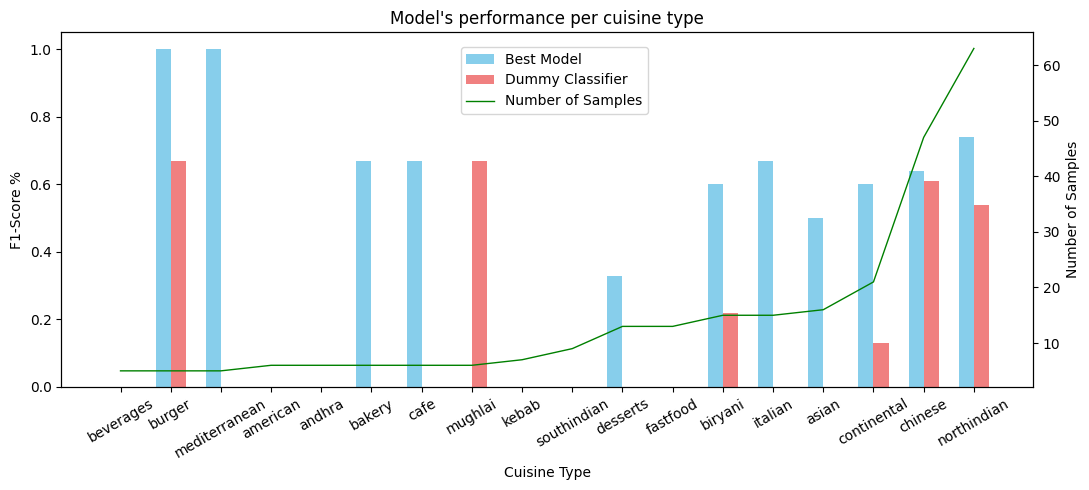

In [90]:
x = np.arange(18)
bar_width = 0.3

fig, ax1 = plt.subplots(figsize=(11, 5))
bars_best = ax1.bar(x - 0.5 * bar_width, f1_best_sorted, bar_width, label='Best Model', color='skyblue')
bars_dummy = ax1.bar(x + 0.5 * bar_width, f1_dummy_sorted, bar_width, label='Dummy Classifier', color='lightcoral')

ax1.set_xlabel('Cuisine Type')
ax1.set_ylabel('F1-Score %')
ax1.set_ylim(0, 1.05)
ax1.set_title("Model's performance per cuisine type")
ax1.set_xticks(x)
ax1.set_xticklabels(classes_sorted, rotation=30)

ax2 = ax1.twinx()
support_line = ax2.plot(support_sorted, color='green', label='Number of Samples', linewidth=1)
ax2.set_ylabel('Number of Samples')

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles.extend(handles2)
labels.extend(labels2)
fig.legend(handles=handles, bbox_to_anchor=[.6,.91])

plt.tight_layout()
plt.show()

The best classifier has a better or equal performance than the dummy classifier in every cuisine, excepting Mughlai , than only contains 2 samples. Given this, we are now sure that our best classifier is undisputably better than the dummy classifier, proving a good performance.

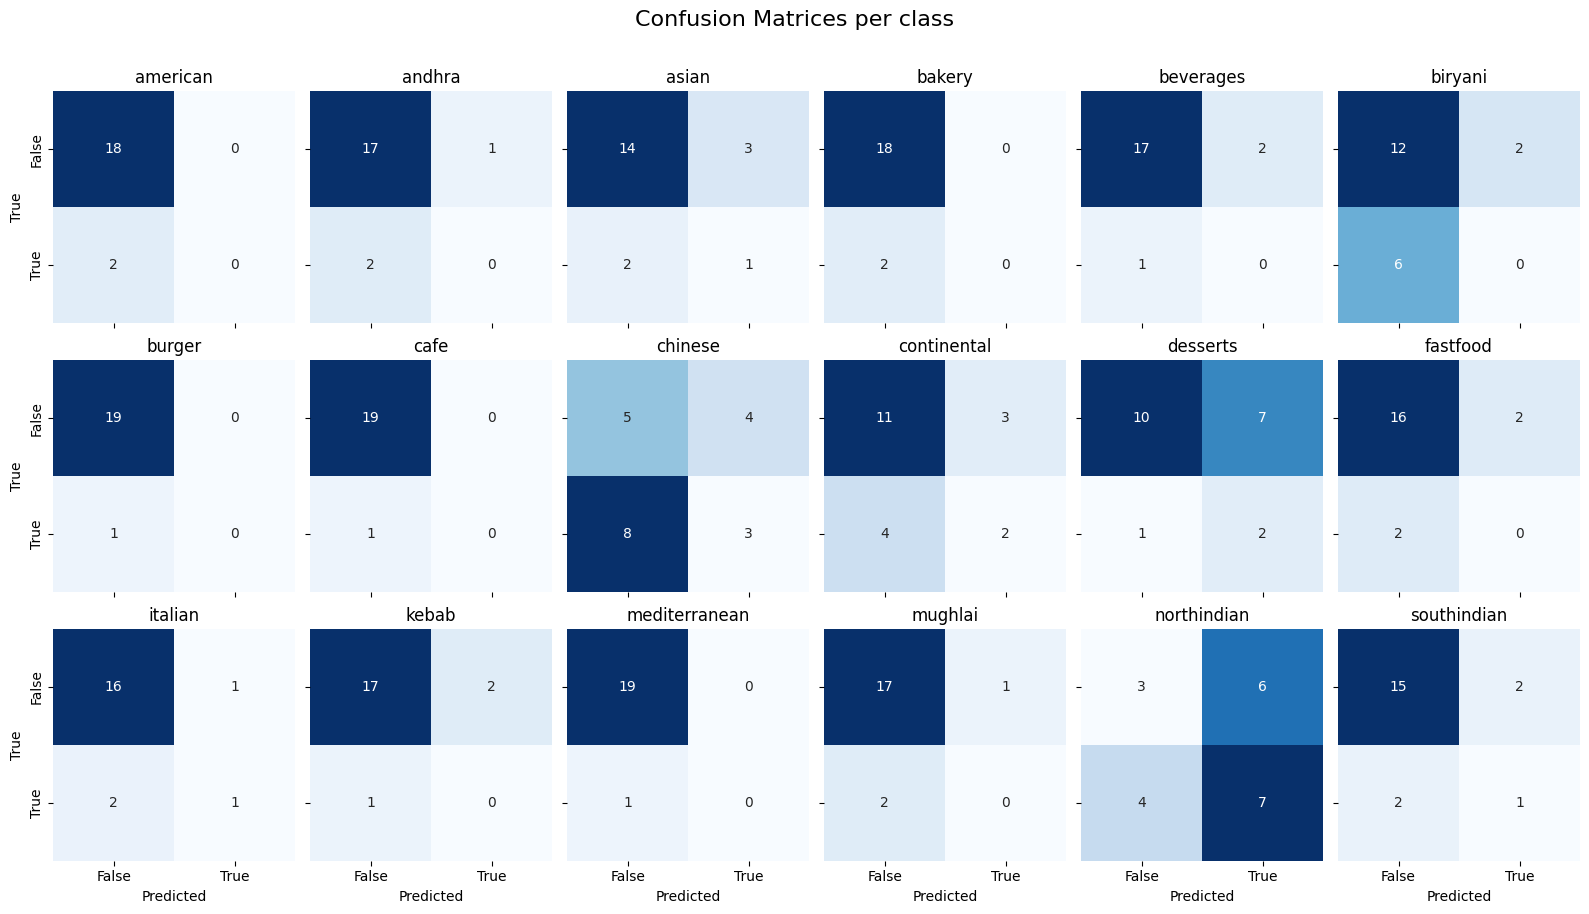

In [93]:
mcm = multilabel_confusion_matrix(y_test, preds)

def plot_confusion_matrix(mcm, rows=3, cols=6):
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(16, 9), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, cuisine in zip(range(len(axes)), mlb.classes_):
        ax = axes[i]
        cm = mcm[i] 
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, ax=ax)
        
        # Add titles and labels
        ax.set_title(f"{cuisine}")

        if i // cols != rows - 1:  
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Predicted")

        if i % cols != 0:  
            ax.set_ylabel("")
        else:
            ax.set_ylabel("True")

        ax.set_xticklabels(["False", "True"])
        ax.set_yticklabels(["False", "True"])
    
    plt.suptitle('Confusion Matrices per class', fontsize=16,y=1.01)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(mcm)

- In most cuisines, the confusion matrix is similar, with a majority of False predicted as such. This is normal given the large number of minority cuisines we have;
- The model is biased after the majority North Indian cuisine, as there is a lot of cases where the label is false and it is predicted as true.


Recapping the IR: **How well can we classify a restaurant’s cuisine type using the 
content of their reviews as input?**


**Answer:** The multilabel classification model performed well for majority cuisine types such as North Indian and Chinese, achieving satisfactory results due to their frequency in the dataset. However, for minority cuisine types, the model's performance was limited, indicating bias towards the most common cuisines. Despite this limitation, the model outperformed a dummy classifier across all global metrics and demonstrated its robustness with stratified k-fold cross-validation..


# <font color='#BFD72F' size=5>4. Sentiment Analysis (Information Requirement 3312)</font> <a class="anchor" id="P1"></a>

**How well can we predict a restaurant’s Zomato score using the 
polarity of their reviews as input?**
  
[Back to TOC](#toc)

#### Specific Data Preparation

Main steps:
- Applied our cleaning pipeline specifically adapted to sentiment analysis (including stopwords, maintaining uppercases, etc.) with three different approaches: to the entire reviews; to every sentence of a review; and to every paragraph of a review.

In [94]:
# Creating the new dataset
sentimentdata = data.copy()[["Restaurant", "Score", "Review"]].rename({"Review": "raw_text"}, axis=1)
sentimentdata.sample(5)

Restaurant  Score  \
11                                   B-Dubs  4.810   
19  Cascade - Radisson Hyderabad Hitec City  4.260   
0                         10 Downing Street  3.800   
30                              Driven Cafe  3.745   
14                          Behrouz Biryani  2.825   

                                             raw_text  
11  [Best service I’ve experienced in the city, wi...  
19  [It was very good dining experience and food i...  
0   [Went with Collegues for lunch...Good Food.. ....  
30  [Driven is a bike themed cafe where you can ev...  
14  [not received any order from your restaurant, ...

We will treat our reviews in two different ways - by each individual review, and by each sentence on each individual review. Then, we will compare the compound scores of both methods - of the entire review, or the mean of each sentence in a review.

In [95]:
# Exploded the dataset to facilitate the manipulation of preprocessing both by review and sentence
sentimentdata_exploded = sentimentdata.explode("raw_text")

In [96]:
# Specific pipeline implementation suited for sentiment analysis:
sentiment_preprocesser = MainPipeline(no_stopwords=False, lowercase=False, no_punctuation=False, lemmatized=False)

sentimentdata_exploded['preproc_byreview'] = [ sentiment_preprocesser.main_pipeline(raw_text=review) for review in sentimentdata_exploded['raw_text'] ]

sent_tokenizer = PunktSentenceTokenizer()
sentimentdata_exploded['preproc_bysentence'] = [ [ sentiment_preprocesser.main_pipeline(raw_text=sentence) for sentence in sent_tokenizer.tokenize(review)] 
                                                                                                  for review in sentimentdata_exploded['raw_text'] ]

sentimentdata_exploded['preproc_byparagraph'] = [ [ sentiment_preprocesser.main_pipeline(raw_text=paragraph) for paragraph in review.split("\n")] 
                                                                                                    for review in sentimentdata_exploded['raw_text'] ]

In [97]:
# Check the difference in the two distinct methods
sentimentdata_exploded[["preproc_byreview", "preproc_bysentence", "preproc_byparagraph"]].iloc[0].values

array(['Went with Collegues for Good Food .. .. but not so great Staff is not pleasing at all . There were only bothered about taking plates off the table.',
       list(['Went with Collegues for Good Food .. .. but not so great Staff is not pleasing at all.', 'There were only bothered about taking plates off the table.']),
       list(['Went with Collegues for Good Food .. .. but not so great Staff is not pleasing at all . There were only bothered about taking plates off the table.'])],
      dtype=object)

#### Model Implementation

Main steps:
- Generated polarity scores from our treated text of all approaches using both Vader and TextBlob;
- Compared the different scores, normalized them, and then compared them to our target the variable;
- Chosen one of the scores, after visual inspection and their performance on selected metrics;
- Created a linear regression model to predict our target variable using the chosen approach.


Here, we will compare the similarity to the distribution to the restaurants score of the two different approaches we learned: VADER and TextBlob.

In [98]:
vader = SentimentIntensityAnalyzer()

In [99]:
def vader_wrapper(user_review, score="compound"):
    """
    Analyze the sentiment of text using the VADER sentiment analyzer.

    Args:
        user_review (str or list): A single string or a list of strings representing the text(s) to be analyzed.
        score (str, optional): The sentiment score to extract. Defaults to "compound", which is the overall sentiment score ranging from -1 (most negative) to 1 (most positive).
        
    Returns:
        float: The average sentiment score for a list of sentences, or the sentiment score for a single string.
    """
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(vader.polarity_scores(sentence)[score])
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = vader.polarity_scores(user_review)[score]
    return polarity

In [100]:
def textblob_wrapper(user_review):
    """
    Analyze the sentiment of text using the TextBlob sentiment analyzer.

    Args:
        user_review (str or list): A single string or a list of strings representing the text(s) to be analyzed.
        
    Returns:
        float: The average sentiment score for a list of sentences, or the sentiment score for a single string.
    """
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(TextBlob(sentence).sentiment.polarity)
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = TextBlob(user_review).sentiment.polarity
    return polarity

In [102]:
def wrapper_mapper(text_column, wrapper):
    """
    Apply a wrapper function to each element in a text column.

    Args:
        text_column (pandas.Series): A pandas Series containing text data.
        wrapper (function): A function to be applied to each element of the text column.
        
    Returns:
        pandas.Series: A pandas Series where the wrapper function has been applied to each element.
    """
    return text_column.map(lambda review: wrapper(review))

In [103]:
sentimentdata_exploded['vader_polarity_review'] = wrapper_mapper(sentimentdata_exploded["preproc_byreview"], vader_wrapper)
sentimentdata_exploded['vader_mean_polarity_sentence'] = wrapper_mapper(sentimentdata_exploded["preproc_bysentence"], vader_wrapper)
sentimentdata_exploded['vader_mean_polarity_paragraph'] = wrapper_mapper(sentimentdata_exploded["preproc_byparagraph"], vader_wrapper)

sentimentdata_exploded['tb_polarity_review'] = wrapper_mapper(sentimentdata_exploded["preproc_byreview"], textblob_wrapper)
sentimentdata_exploded['tb_mean_polarity_sentence'] = wrapper_mapper(sentimentdata_exploded["preproc_bysentence"], textblob_wrapper)
sentimentdata_exploded['tb_mean_polarity_paragraph'] = wrapper_mapper(sentimentdata_exploded["preproc_byparagraph"], textblob_wrapper)

In [104]:
# Grouping by restaurant and check the mean of each method
compoundscores = sentimentdata_exploded.groupby("Restaurant")[["vader_polarity_review", "vader_mean_polarity_sentence", 
                                                               "vader_mean_polarity_paragraph", "tb_polarity_review", 
                                                               "tb_mean_polarity_sentence", "tb_mean_polarity_paragraph"]].mean().reset_index()

In [105]:
compoundscores.describe()

vader_polarity_review  vader_mean_polarity_sentence  \
count             100.000000                    100.000000   
mean                0.475926                      0.276362   
std                 0.231254                      0.137755   
min                -0.089436                     -0.033596   
25%                 0.319394                      0.199856   
50%                 0.488379                      0.263839   
75%                 0.648093                      0.334881   
max                 0.906472                      0.704215   

       vader_mean_polarity_paragraph  tb_polarity_review  \
count                     100.000000          100.000000   
mean                        0.358385            0.249249   
std                         0.184988            0.113728   
min                        -0.076809           -0.060011   
25%                         0.255540            0.182410   
50%                         0.344059            0.237207   
75%                         0.451312            0.317509   
max                         0.805268            0.582866   

       tb_mean_polarity_sentence  tb_mean_polarity_paragraph  
count                 100.000000                  100.000000  
mean                    0.227108                    0.227554  
std                     0.100749                    0.107904  
min                    -0.029650                   -0.048379  
25%                     0.163261                    0.159759  
50%                     0.221456                    0.211738  
75%                     0.275427                    0.280525  
max                     0.561461                    0.547726

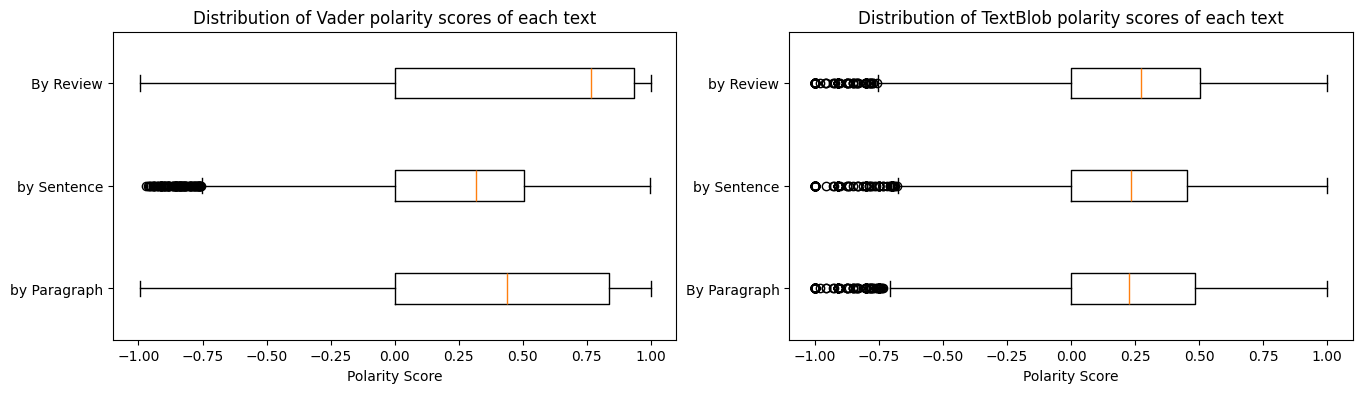

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(16,4), sharex=True)

ax[0].boxplot([sentimentdata_exploded['vader_mean_polarity_paragraph'], sentimentdata_exploded['vader_mean_polarity_sentence'],
                sentimentdata_exploded['vader_polarity_review']], vert=False, patch_artist=False)
ax[0].set_yticks([1, 2, 3], ['by Paragraph', 'by Sentence', "By Review"])
ax[0].set_title("Distribution of Vader polarity scores of each text")
ax[0].set_xlabel("Polarity Score")

ax[1].boxplot([sentimentdata_exploded['tb_mean_polarity_paragraph'], sentimentdata_exploded['tb_mean_polarity_sentence'], 
               sentimentdata_exploded['tb_polarity_review']], vert=False, patch_artist=False)
ax[1].set_title("Distribution of TextBlob polarity scores of each text")
ax[1].set_yticks([1, 2, 3], ['By Paragraph', 'by Sentence', 'by Review'])
ax[1].set_xlabel("Polarity Score")

plt.show()

- VADER by Review and Paragraph tend to have a wider distributions, and to output more positive scores than VADER By Sentence;
- The TextBlob methods have all similar distributions, similar to VADER By Sentence.

Let's now check the distributions of the mean polarity scores of each restaurant, instead of text by text:

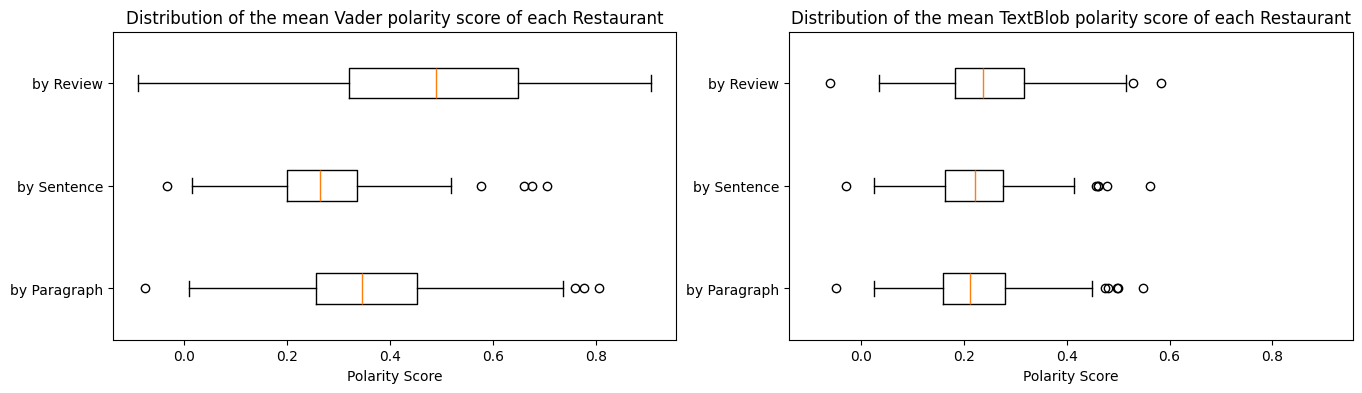

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(16,4), sharex=True)

ax[0].boxplot([compoundscores['vader_mean_polarity_paragraph'], compoundscores['vader_mean_polarity_sentence'], 
               compoundscores['vader_polarity_review']], vert=False, patch_artist=False)
ax[0].set_yticks([1, 2, 3], ['by Paragraph', 'by Sentence', 'by Review'])
ax[0].set_title("Distribution of the mean Vader polarity score of each Restaurant")
ax[0].set_xlabel("Polarity Score")

ax[1].boxplot([compoundscores['tb_mean_polarity_paragraph'], compoundscores['tb_mean_polarity_sentence'], 
               compoundscores['tb_polarity_review']], vert=False, patch_artist=False)
ax[1].set_title("Distribution of the mean TextBlob polarity score of each Restaurant")
ax[1].set_yticks([1, 2, 3], ['by Paragraph', 'by Sentence', 'by Review'])
ax[1].set_xlabel("Polarity Score")

plt.show()

When comparing with the boxplots above, we can see that:
- By grouping the scores by restaurant we get way thinner distributions, what makes sense as we are taking the mean of the scores of each restaurant we are neutralizing extreme values.
- VADER by Review keeps being the more positive polarity, and wider distribution;
- TextBlob polarity scores keep being very similar between each other.

Now we must compare the different polarity scores obtained above to the real restaurants scores, in order to know what method is the best approach to predict them. Before anything, it is better to normalize all values:

In [108]:
def score_normalizer(score_col, df=compoundscores):
    """
    Normalize a column of scores in a dataframe to a range of [0, 1] using Min-Max Scaling.

    Args:
        score_col (str): The name of the column in the dataframe containing the scores to be normalized.
        df (pandas.DataFrame, optional): The dataframe containing the column to normalize. Defaults to `compoundscores`.
        
    Returns:
        numpy.ndarray: A 1D array of normalized scores, scaled to the range [0, 1].
    """
    scaler = MinMaxScaler() # [0, 1] range
    return scaler.fit_transform(df[score_col].to_numpy().reshape(-1, 1)).reshape(-1)

In [109]:
compoundscores["normalized_score"] = score_normalizer("Score", df=sentimentdata)

compoundscores["normalized_polarity_vader_review"] = score_normalizer("vader_polarity_review")
compoundscores["normalized_polarity_vader_sentence"] = score_normalizer("vader_mean_polarity_sentence")
compoundscores["normalized_polarity_vader_paragraph"] = score_normalizer("vader_mean_polarity_paragraph")

compoundscores["normalized_polarity_tb_review"] = score_normalizer("tb_polarity_review")
compoundscores["normalized_polarity_tb_sentence"] = score_normalizer("tb_mean_polarity_sentence")
compoundscores["normalized_polarity_tb_paragraph"] = score_normalizer("tb_mean_polarity_paragraph")

In [110]:
compoundscores[["normalized_score", "normalized_polarity_vader_review", "normalized_polarity_vader_sentence", "normalized_polarity_vader_paragraph",
                "normalized_polarity_tb_review", "normalized_polarity_tb_sentence", "normalized_polarity_tb_paragraph"]].describe()

normalized_score  normalized_polarity_vader_review  \
count        100.000000                        100.000000   
mean           0.484689                          0.567685   
std            0.204881                          0.232204   
min            0.000000                          0.000000   
25%            0.340726                          0.410509   
50%            0.489919                          0.580190   
75%            0.583165                          0.740560   
max            1.000000                          1.000000   

       normalized_polarity_vader_sentence  \
count                          100.000000   
mean                             0.420104   
std                              0.186708   
min                              0.000000   
25%                              0.316412   
50%                              0.403132   
75%                              0.499419   
max                              1.000000   

       normalized_polarity_vader_paragraph  normalized_polarity_tb_review  \
count                           100.000000                     100.000000   
mean                              0.493374                       0.481055   
std                               0.209719                       0.176904   
min                               0.000000                       0.000000   
25%                               0.376780                       0.377087   
50%                               0.477133                       0.462325   
75%                               0.598724                       0.587235   
max                               1.000000                       1.000000   

       normalized_polarity_tb_sentence  normalized_polarity_tb_paragraph  
count                       100.000000                        100.000000  
mean                          0.434365                          0.462893  
std                           0.170441                          0.181016  
min                           0.000000                          0.000000  
25%                           0.326354                          0.349164  
50%                           0.424804                          0.436361  
75%                           0.516107                          0.551755  
max                           1.000000                          1.000000

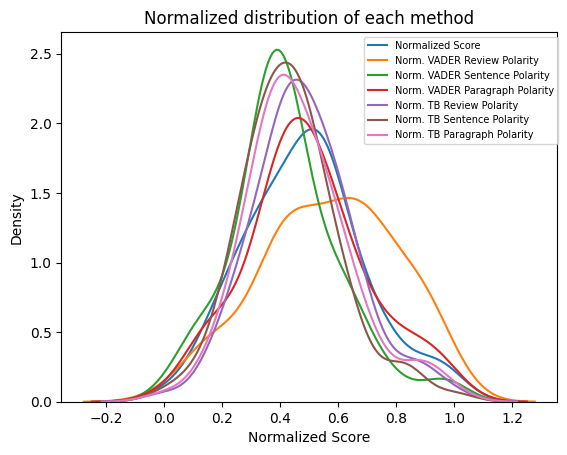

In [111]:
sns.kdeplot(compoundscores["normalized_score"], label="Normalized Score")
sns.kdeplot(compoundscores["normalized_polarity_vader_review"], label="Norm. VADER Review Polarity")
sns.kdeplot(compoundscores["normalized_polarity_vader_sentence"], label="Norm. VADER Sentence Polarity")
sns.kdeplot(compoundscores["normalized_polarity_vader_paragraph"], label="Norm. VADER Paragraph Polarity")
sns.kdeplot(compoundscores["normalized_polarity_tb_review"], label="Norm. TB Review Polarity")
sns.kdeplot(compoundscores["normalized_polarity_tb_sentence"], label="Norm. TB Sentence Polarity")
sns.kdeplot(compoundscores["normalized_polarity_tb_paragraph"], label="Norm. TB Paragraph Polarity")
plt.title("Normalized distribution of each method")
plt.xlabel("Normalized Score")
plt.legend(loc="upper left", bbox_to_anchor=(0.6, 1), fontsize=7)
plt.show()

- No polarity score is very close to the normalized restaurant score;
- VADER by Sentence, TextBlob by Sentence and by Review (the closest), seem to have similar distributions to the restaurant score, but have a higher kurtosis;
- VADER by Review seems to have a different distribution to the rest.

Let's confirm our visual guesses with metrics:

In [112]:
methods = compoundscores.set_index("Restaurant").iloc[:, 7:15].columns
labels = ["VADER by Review", "VADER by Sentence", "VADER by Paragraph", "TextBlob by Review", "TextBlob by Sentence", "TextBlob by Paragraph"]

df = pd.DataFrame(columns=["RMSE", "MAPE"])
for polarity_method, label in zip(methods, labels):
    df = pd.concat([df, 
                    pd.DataFrame([{'RMSE': round(root_mean_squared_error(compoundscores.normalized_score, compoundscores[polarity_method]), 5), 
                                         'MAPE': round(mean_absolute_percentage_error(np.array(compoundscores.normalized_score).reshape(-1)+1, np.array(compoundscores[polarity_method]).reshape(-1)+1), 5)}]
                                         , index=[label])],)

df

RMSE     MAPE
VADER by Review        0.14988  0.08996
VADER by Sentence      0.10595  0.05895
VADER by Paragraph     0.08833  0.05015
TextBlob by Review     0.07334  0.03944
TextBlob by Sentence   0.09259  0.05076
TextBlob by Paragraph  0.08117  0.04370

Let's check the ranks:

In [113]:
df.rank(ascending=True)

RMSE  MAPE
VADER by Review         6.0   6.0
VADER by Sentence       5.0   5.0
VADER by Paragraph      3.0   3.0
TextBlob by Review      1.0   1.0
TextBlob by Sentence    4.0   4.0
TextBlob by Paragraph   2.0   2.0

The metrics above confirms that using TextBlob by Review give us the best results! We will use it to try to predict the restaurant scores.

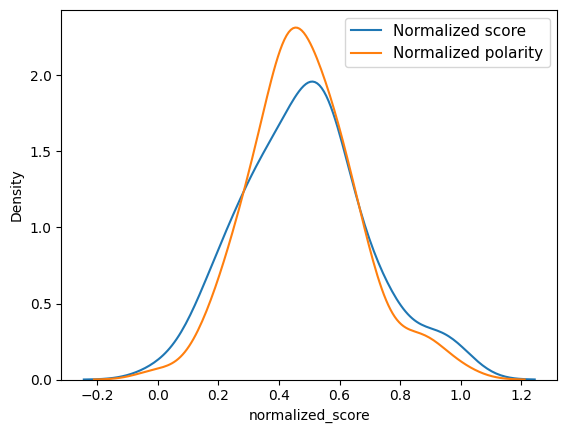

In [114]:
sns.kdeplot(compoundscores.normalized_score)
sns.kdeplot(compoundscores.normalized_polarity_tb_review)
plt.legend(["Normalized score", "Normalized polarity"], fontsize=11)
plt.show()

Now let's try to create a model that receives as input the Vader polarity score of the reviews of a restaurant, and outputs a predicted restaurant score:

In [115]:
X = np.array( compoundscores.tb_polarity_review ).reshape(-1, 1)
y = np.array( sentimentdata.Score ).reshape(-1, 1)

It seems that the restaurants' and polarity scores are naturally correlated

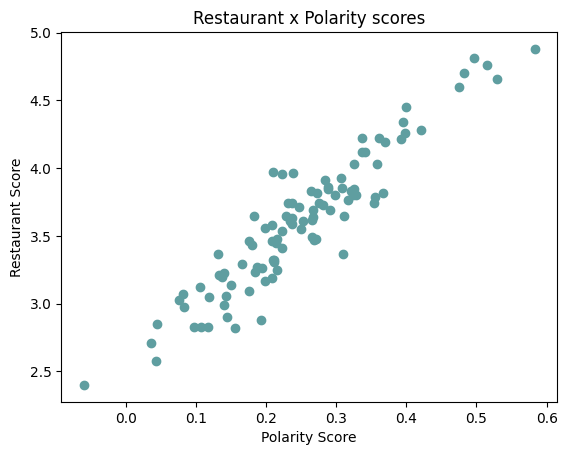

In [116]:
plt.scatter(X, y, color="cadetblue")
plt.title("Restaurant x Polarity scores")
plt.ylabel("Restaurant Score")
plt.xlabel("Polarity Score")
plt.show()

Just by looking at this plot we can see that there are no contraditary outliers (observations that got one of the scores very high and the other very low)

In [117]:
# Splitting our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [118]:
model = LinearRegression()
model = model.fit(X_train, y_train)

In [119]:
intercept = model.intercept_[0]
slope = model.coef_[0][0]

print(f"Intercept: {round(intercept, 5)} ; Coefficient: {round(slope, 5)} ")

Intercept: 2.58045 ; Coefficient: 4.17943 


**Fitted model:**

**restaurantScore = 2.58  + 4.179 x polarityTextBlobByReview**

#### Model Evaluation

The best model seems to have an excelent fit over the data points. This is facilitated because the two variables seem to be almost perfectly correlated.

In [120]:
plt.scatter(X, y, color="cadetblue")
plt.plot(X, slope*X + intercept, color = 'darkred')
plt.title('Restaurants vs Polarity scores')
plt.xlabel('Polarity Score')
plt.ylabel('Restaurant Score')
plt.legend(["Data Points", "Best model fit"])
plt.show()

In [121]:
pearson_r, p_value = pearsonr(sentimentdata.Score, compoundscores.tb_polarity_review)
print(f"The correlation between the restaurant ratings and the best polarity method is {round(pearson_r, 3)}")

The correlation between the restaurant ratings and the best polarity method is 0.936


As said before, we can confirm that the two variables are almost perfectly correlated.

Checking metrics:

In [122]:
y_pred_train = model.predict(X_train)
print(f"Train RMSE: {root_mean_squared_error(y_train, y_pred_train)} ")
print(f"Train MAPE: {mean_absolute_percentage_error(y_train, y_pred_train)} ")
print()
y_pred_test = model.predict(X_test)
print(f"Test RMSE: {root_mean_squared_error(y_test, y_pred_test)} ")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred_test)} ")

Train RMSE: 0.1764257535471652 
Train MAPE: 0.038438547976495686 

Test RMSE: 0.18920766298006395 
Test MAPE: 0.04620486784103787 


- RMSE: The square root of the average of squared differences between the predictions and actual values is around 0.18.
- MAPE: The average difference between the prediction and actual value is only around 4%.

Checking the descriptive statistics:

In [123]:
compoundscores[["normalized_score", "normalized_polarity_tb_review"]].describe()

normalized_score  normalized_polarity_tb_review
count        100.000000                     100.000000
mean           0.484689                       0.481055
std            0.204881                       0.176904
min            0.000000                       0.000000
25%            0.340726                       0.377087
50%            0.489919                       0.462325
75%            0.583165                       0.587235
max            1.000000                       1.000000

There is barely a difference between both normalized scores. The means are almost the same, and the medians only differ by around 0.028 (the equivalent to 0.14 restaurant rating stars ( (1 * 0.028) / 0.2) )

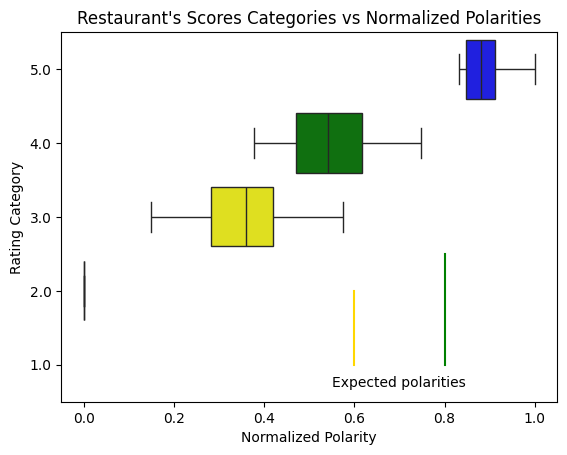

In [124]:
compoundscores["overall_cat"] = sentimentdata["Score"].round().apply(lambda score : str(score))
sns.boxplot(data=compoundscores, x="normalized_polarity_tb_review", y="overall_cat", order=["5.0", "4.0", "3.0", "2.0", "1.0"], 
            palette=["blue", "green", "yellow", "red"])

plt.axvline(0.6, 0.1, 0.3, color="gold")
plt.axvline(0.8, 0.1, 0.4, color="green")
plt.text(0.55, 4.3, "Expected polarities")
plt.xlabel("Normalized Polarity")
plt.ylabel("Rating Category")
plt.title("Restaurant's Scores Categories vs Normalized Polarities")
plt.show()

- There is the expected clear upward trend, as the categories increase polarity also tend to;
- Most of sentiments extracted belong to categories 3 and 4 (wider distributions, with a bigger spread);
- Reviewers tend to overact when assigning ratings 0-5, doing it at will (assuming that polarity is the true feeling of reviewers). This is evident as in every category the median polarity does not correspond to the right category:
    - Category 2, expected to have a norm. polarity of 0.4 (2/5), has a median polarity of around 0. This shows us that even when the reviews are absolutely terrible customers still do not give the lowest possible ratings;
    - Categories 3 and 4, expected to have a norm. polarity of 0.6 and 0.8 respectively, have median polarities just below 0.4 and 0.6.
    - Category 5, expected to have a norm. polarity of 1, has a median polarity of just over 0.8. However, this can be more understandable, as every rating assigned that is not a 5 would bring the median down.

For the following visualization will have to use Vader, as TextBlob does not compute the "positive", "neutral" and "negative" of reviews.

In [125]:
plot_data = pd.DataFrame(sentimentdata_exploded["preproc_byparagraph"].values, 
                         reviews.Time.values).reset_index().rename({"index":"time", 0: "review"}, axis=1)

plot_data.head()

time                                             review
0 2019-02-01 15:19:00  [Went with Collegues for Good Food .. .. but n...
1 2018-12-21 05:47:00  [Great place and a really amazing crowd . The ...
2 2018-12-26 06:52:00  [A grand entry, decent ambience and average fo...
3 2018-12-26 10:52:00  [The ambience along with the roof top view was...
4 2018-12-28 15:52:00  [While the food is pretty similar and standard...

In [126]:
plot_data['neg'] = plot_data["review"].map(lambda review: vader_wrapper(review, "neg")*100)
plot_data['neu'] = plot_data["review"].map(lambda review: vader_wrapper(review, "neu")*100)
plot_data['pos'] = plot_data["review"].map(lambda review: vader_wrapper(review, "pos")*100)
plot_data["Q"] = plot_data['time'].dt.to_period('Q')

In [127]:
plot_data.sort_values("time", inplace=True)
plot_data_final = plot_data.groupby("Q")[["neg", "neu", "pos"]].mean()
plot_data_final.head()

neg        neu        pos
Q                                     
2016Q2  2.272727  64.600087  20.011147
2016Q3  2.902885  75.172863  16.368697
2016Q4  2.398045  73.792440  18.216131
2017Q1  2.001284  68.938020  19.540672
2017Q2  2.006310  69.641139  16.474163

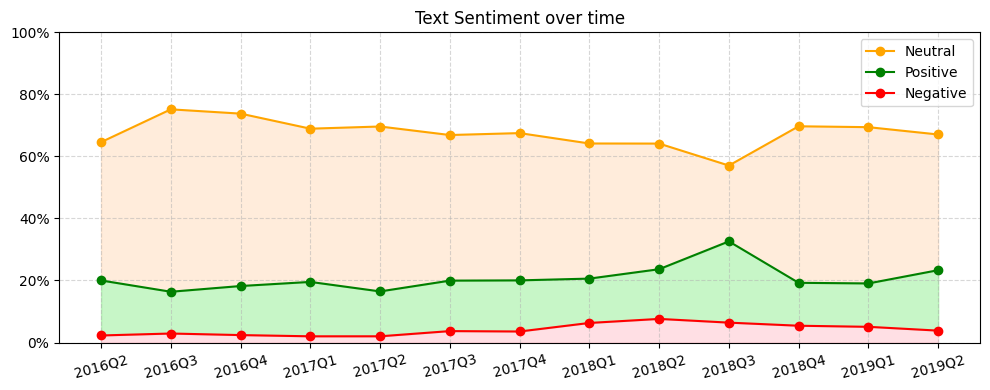

In [128]:
positive = plot_data_final.pos
neutral = plot_data_final.neu
negative = plot_data_final.neg
years = plot_data_final.index.astype(str)

plt.figure(figsize=(10, 4))

plt.plot(years, neutral, marker='o', color='orange', label='Neutral')
plt.plot(years, positive, marker='o', color='green', label='Positive')
plt.plot(years, negative, marker='o', color='red', label='Negative')

# Fill the spaces between lines
plt.fill_between(years, neutral, positive, color='peachpuff', alpha=0.5)
plt.fill_between(years, positive, negative, color='lightgreen', alpha=0.5) 
plt.fill_between(years, negative, 0, color='pink', alpha=0.5)  

plt.ylim(0, 100)
plt.yticks(np.arange(0, 110, 20), labels=['0%', '20%', '40%', '60%', '80%', '100%'])
plt.xticks(years, rotation=15)
plt.grid(linestyle='--', alpha=0.5)
plt.title("Text Sentiment over time")
plt.legend()

plt.tight_layout()
plt.show()

- Neutrality dominated the distribution of reviews' sentiment, with its lowest share (less than 60%) still being a majority. It started with over 65% of sentiments, remained somewhat constant over time, with a few fluctuations.
- Positive sentiment is the 2nd highest sentiment, with values around 20%.
- Negativity is the subjugated sentiment, not achieving even a share of 10% of sentiments.
- In the 3rd quarter of 2018 something that triggered positivity happened, as there were a high transfer of neutral to positve sentiments.

Recapping the IR: **How well can we predict a restaurant’s Zomato score using the 
polarity of their reviews as input?**

**Answer:** We analysed the relationship between a restaurant’s review polarity scores and its Zomato score. The polarity scores correlated closely with the restaurant's scores, indicating that review sentiment is a strong predictor of restaurant ratings. To quantify this, we built a simple regression model that uses the average polarity score of a restaurant as input to predict its Zomato score. The model’s predictions have a mean error of only about 4%, indicating high precision in predicting Zomato scores. Given this, we can say that we are able to predict a restaurant’s Zomato score using the 
polarity of their reviews as input very well.

# <font color='#BFD72F' size=5>5. Co-occurrence Analysis & Clustering (Information Requirement 3321)</font> <a class="anchor" id="P1"></a>

- **What dishes are mentioned together in the reviews?**
- **Do they form clusters?**
- **Can you identify cuisine types based on those clusters?**
  
[Back to TOC](#toc)

#### Specific Data Preparation

Main steps:
- Applied the cleaning pipeline adjusted to Name-Entity Recognition, together with the *en_core_web_sm* model from Spacy for extracting tokens, POS and NER tags;
- Integrated a ingredient dataset that will be useful when separating them from real dishes.

Creating a dataframe with the relevant features for this information requirement:

In [46]:
cooccurrencedata = data.copy()[['Review']].rename({"Review":"raw_text"}, axis=1).explode("raw_text")

In [47]:
nlp = spacy.load("en_core_web_sm")

Then, we created columns to store the POS and tokens, applying the pipeline adjusted to Name-Entity Recognition. 

Obs: we did not see a problem on lowercasing all tokens, as our focus are in dishes, where normally are all in lowercase. If the focus was on extracting for instance, countries, companies or events, it would not be a good option.

In [48]:
text_preprocesser = MainPipeline(no_stopwords=False, no_punctuation=False, lemmatized=False, tokenized_output=False)
cooccurrencedata['processed_text'] = cooccurrencedata.raw_text.apply(lambda review: text_preprocesser.main_pipeline(review) )
cooccurrencedata['spacy_tokens'] = cooccurrencedata.raw_text.apply(lambda review: nlp( text_preprocesser.main_pipeline(review)) )
cooccurrencedata['spacy_POS'] = cooccurrencedata.spacy_tokens.apply(lambda review: [str( token.pos_ ) for token in review] )
# Converting the spacy tokens into strings as it is easier to manage
cooccurrencedata['spacy_tokens'] = cooccurrencedata.spacy_tokens.apply(lambda review: [str(token) for token in review])

In [49]:
cooccurrencedata.head()

raw_text  \
0  Went with Collegues for lunch...Good Food.. .....   
0  Great place and a really amazing crowd. The am...   
0  A grand entry, decent ambience and average foo...   
0  The ambience along with the roof top view was ...   
0  While the food is pretty similar and standard ...   

                                      processed_text  \
0  went with collegues for good food .. .. but no...   
0  great place and a really amazing crowd . the a...   
0  a grand entry, decent ambience and average foo...   
0  the ambience along with the roof top view was ...   
0  while the food is pretty similar and standard ...   

                                        spacy_tokens  \
0  [went, with, collegues, for, good, food, .., ....   
0  [great, place, and, a, really, amazing, crowd,...   
0  [a, grand, entry, ,, decent, ambience, and, av...   
0  [the, ambience, along, with, the, roof, top, v...   
0  [while, the, food, is, pretty, similar, and, s...   

                                           spacy_POS  
0  [VERB, ADP, NOUN, ADP, ADJ, NOUN, PUNCT, PUNCT...  
0  [ADJ, NOUN, CCONJ, DET, ADV, ADJ, NOUN, PUNCT,...  
0  [DET, ADJ, NOUN, PUNCT, ADJ, NOUN, CCONJ, ADJ,...  
0  [DET, NOUN, ADP, ADP, DET, ADJ, ADJ, NOUN, AUX...  
0  [SCONJ, DET, NOUN, AUX, ADV, ADJ, CCONJ, ADJ, ...

Spacy's NER models don't have a food or dish tag, so it does not make sense to apply it.

Now we will try to extract foods/ingredients names, that are not dishes, from an external Kaggle dataset. These will be very helpful to get only really dishes.

In [50]:
foods_not_dishes = pd.read_csv('ner_data/food_ingredients_and_allergens.csv')
foods_not_dishes.head(2)

Food Product Main Ingredient Sweetener Fat/Oil Seasoning  \
0  Almond Cookies         Almonds     Sugar  Butter     Flour   
1  Almond Cookies         Almonds     Sugar  Butter     Flour   

               Allergens Prediction  
0  Almonds, Wheat, Dairy   Contains  
1  Almonds, Wheat, Dairy   Contains

In [51]:
foods_not_dishes.drop(['Food Product', 'Prediction'], axis=1, inplace=True)

for col in foods_not_dishes:
    # Converting string lists into real lists
    foods_not_dishes[col] = foods_not_dishes[col].apply( lambda item: item.split(', ') if isinstance(item, str) else item )
    # Removing foods with two words (potential dishes)
    foods_not_dishes[col] = foods_not_dishes[col].apply( lambda item: [x for x in item if ' ' not in x] if isinstance(item, list) else item )

foods_not_dishes.head(2)

Main Ingredient Sweetener   Fat/Oil Seasoning                Allergens
0       [Almonds]   [Sugar]  [Butter]   [Flour]  [Almonds, Wheat, Dairy]
1       [Almonds]   [Sugar]  [Butter]   [Flour]  [Almonds, Wheat, Dairy]

In [52]:
# Extraction every food name
foods = list(np.unique([item.lower() 
                for col in foods_not_dishes 
                    for lt in foods_not_dishes[col].values if isinstance(lt, list)
                        for item in lt]))

foods.extend(['bread', 'beer', 'fries', 'pickle'])
print(foods[80:100])

['oil', 'olives', 'onion', 'onions', 'oranges', 'pancetta', 'paneer', 'paprika', 'pasta', 'pastry', 'peanuts', 'peas', 'pecans', 'pectin', 'pepper', 'pineapple', 'popcorn', 'pork', 'potato', 'potatoes']


#### Model Implementation

Main steps:
- Applied a pre-trained BERT model, tailored for food extraction, that didn't lead to good results;
- Then, tried a rule-based approach, based on n-grams of tokens and POS, in order to extract dish names, that led a better outcome
- Fixed specificities like misspellings, ingredients in the dish list, singular/plural redundancies, and x-word dishes
- Computed a cooccurrence matrix between all dishes, that was later transformed in a distance matrix;
- Created clusters of dishes based on the distance matrix;
- Extracted the most frequent cuisine types from each cluster.

We will implement a pre-trained BERT model tailored for food extraction in our data, in order to try extracting dish names:

In [146]:
tokenizer = AutoTokenizer.from_pretrained("Dizex/FoodBaseBERT-NER")
model = AutoModelForTokenClassification.from_pretrained("Dizex/FoodBaseBERT-NER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

In [147]:
def merge_entities(ner_results):
    merged_entities = []
    current_entity = None

    for result in ner_results:
        # If it's the same entity type as the previous one, we append the token
        if current_entity and current_entity['entity'] == result['entity']:
            current_entity['word'] += " " + result['word']
        else:
            # If it's a new entity, store the current entity and start a new one
            if current_entity:
                merged_entities.append(current_entity)
            current_entity = result

    # Add the last entity to the list
    if current_entity:
        merged_entities.append(current_entity)

    return merged_entities

In [148]:
dishes = {}

# Process dataset with NER pipeline
for text in tqdm(cooccurrencedata.processed_text):
    entities = ner_pipeline(text)
    
    # Merge multi-token entities
    merged_entities = merge_entities(entities)

    # Add merged entities to the all_entities list
    for ent in merged_entities:
        word = ent['word']
        if '#' not in word:  # Ensure we only add the full entity (without subwords)
            if word in dishes:
                dishes[word] += 1
            else:
                dishes[word] = 1

100%|██████████| 9955/9955 [18:58<00:00,  8.75it/s]


In [149]:
print(sorted(dishes.items(), key=lambda x:x[1], reverse=True)[:150])

[('food', 1719), ('chicken', 1494), ('rice', 309), ('cream', 212), ('fish', 188), ('chocolate', 170), ('sauce', 169), ('butter', 169), ('corn', 155), ('ice', 153), ('pizza', 149), ('cake', 144), ('cheese', 134), ('soup', 134), ('dishes', 129), ('cuisine', 120), ('food food', 117), ('wings', 114), ('fried', 106), ('items', 99), ('starter', 97), ('music', 93), ('coffee', 90), ('egg', 88), ('drinks', 87), ('pieces', 85), ('bi', 84), ('mushroom', 83), ('fried rice', 80), ('garlic', 78), ('bread', 77), ('ma', 74), ('delicious', 73), ('hot', 70), ('beer', 69), ('lovers', 67), ('ice cream', 63), ('in', 61), ('lemon', 61), ('k', 57), ('fresh', 56), ('water', 56), ('potato', 55), ('salad', 55), ('cakes', 55), ('sweet', 54), ('taste', 52), ('dessert', 51), ('lunch', 50), ('red', 50), ('gold', 50), ('t', 49), ('sandwich', 48), ('s', 47), ('fruit', 46), ('food chicken', 45), ('pork', 43), ('meat', 41), ('shake', 41), ('meal', 40), ('options', 38), ('dish', 38), ('juice', 37), ('drink', 37), ('pan'

The pre-trained model was not very effective extracting dishes. We can see there some foods, ingredients, and even some dishes, but a big part of words extracted does not fit into our requirement. Given this, we will have to follow other approach:

Let's try to follow a rule-based approach, based on the 2-token neighborhood of each token. To start, we need to create 5-grams:

In [53]:
def generate_ngrams(tokens, n=5):
    """
    Generate n-grams from a list of tokens.

    Args:
        tokens (list): A list of tokens (e.g., words or parts of speech) to generate n-grams from.
        n (int, optional): The size of the n-grams to generate. Defaults to 5.
        
    Returns:
        list: A list of n-grams, where each n-gram is represented as a list of `n` consecutive tokens.
    """
    return [tokens[i:i+n] for i in range(len(tokens) - n + 1)]

In [54]:
tokens_ngrams = []
tokens_POS = []

for tokens, pos in cooccurrencedata[['spacy_tokens', 'spacy_POS']].values:
    if len(tokens) >= 5:  # Ensure there are enough tokens for 5-grams
        tokens_ngrams.extend(generate_ngrams(tokens))
        tokens_POS.extend(generate_ngrams(pos))

We also need to filter out the most common words, that will appear a lot of times independently of the conditions we enforce.

In [55]:
most_freq_words = word_freq_calculator(word_matrix, words)
most_freq_words[:50].words.values 

array(['good', 'food', 'place', 'service', 'order', 'chicken', 'taste',
       'ambience', 'time', 'one', 'great', 'try', 'like', 'visit',
       'really', 'go', 'also', 'nice', 'best', 'serve', 'restaurant',
       'staff', 'get', 'biryani', 'veg', 'experience', 'well', 'even',
       'make', 'love', 'bad', 'would', 'dish', 'must', 'give', 'starter',
       'come', 'quality', 'amaze', 'awesome', 'friend', 'price', 'take',
       'rice', 'overall', 'dont', 'recommend', 'paneer', 'item', 'menu'],
      dtype=object)

In [56]:
remove_words = [word for word in ["drinks", "starters", "desserts", "death", "audacity", "loads", "combo", "lighting", "pastries",
                                  "stomach", "vomitings", "courtesy","pleasure", "thrice", "succulent", "shake", "shakes", 
                                  "chef", "couple", "today", "breakfast", "alot", "lots", "presentation", "prawn", "juices"
                                  "opportunity", "fun",  "gold", "dance", "home", "snacks", "crispy"] + list(most_freq_words[:150].words.values)
                # Keeping some of the most frequent words that are potential dishes                  
                if word not in ['chicken', 'biryani', 'rice', 'paneer', 'pizza', 'fish', 'ice', 'cream', 'cake', 'mutton', 'soup', 'sweet'
                                'kebab', 'corn', 'masala', 'noodle', 'curry', 'cheese', 'burger', 'tikka', 'butter', 'chocolate'] ]

Now, our workflow was searching for nouns, that were surrounded by the following neighbourhoods:
- tried/had/ordered (the) *dish* (1-3 points, depending of the number of words on the dish)
- : *dish* (0.5 points)
- , *dish* , / and /.  (1-2 points, depending of the number of words on the dish)
- best *dish* ever (0.5 points)

Each of these have a different weight (points) to the final score, depending of how exclusive this expression are to dishes.

In [57]:
dish_scores = {}

def add_dish(dish, amount=1):
    """Helper function to add a dish to the dishes dictionary."""
    if dish not in dish_scores:
        dish_scores[dish] = amount
    else:
        dish_scores[dish] += amount

# Iterating over every every 5-gram of tokens and POS, together
for ngram_token, ngram_pos in zip(tokens_ngrams, tokens_POS):

    # If the middle token is not in the remove words list, and it is a noun
    if ngram_token[2] not in remove_words and ngram_pos[2] == 'NOUN':

        # And if it is preceded by the verbs tried or had or ordered
        if (( ngram_token[1] == "the" ) and ( ngram_token[0] in ["tried", "had", "ordered"]) or (ngram_token[1] in ["tried", "had", "ordered"])):
            dish = ngram_token[2]

            # Possibility of the dish having more than one word
            if ngram_pos[3] == 'NOUN' and ngram_token[3] not in remove_words:
                dish += ' '+str(ngram_token[3])

                # Possibility of the dish having more than two words
                if ngram_pos[4] == 'NOUN' and ngram_token[4] not in remove_words:
                    dish += ' '+str(ngram_token[4])
                    add_dish(dish, amount=3)

                else:
                    add_dish(dish, amount=2)

            else:
                add_dish(dish)

        # Dish preceded by :
        if ngram_token[1] == ':':
            add_dish(ngram_token[2], amount=0.5)
        
        # Dishes between commas, ands, and dots
        if ( (ngram_token[1] == ',') and (ngram_token[3] in [',', 'and', '.']) ) :
            add_dish(ngram_token[2])

        # Dishes with more than 1 word with the same pattern
        if (ngram_token[1] == ',') and (ngram_pos[3] == 'NOUN' and ngram_token[3] not in remove_words) and (ngram_token[4] in [',', 'and', '.']):
            dish = ngram_token[2] + ' ' + ngram_token[3]
            add_dish(dish, amount=2)

        # Dishes surrounded by best ... ever
        if ( (ngram_token[1] == 'best') and (ngram_token[3] == 'ever') or (ngram_token[1] == 'best') and (ngram_pos[3] == 'NOUN'  
                                                                                                        and ngram_token[3] not in remove_words)
                                                                                                            and (ngram_token[4] == 'ever')):
            add_dish(ngram_token[2], amount=0.5)
            
                
len(dish_scores)

994

There are some dishes that are present multiple times in the list, for instance in singular and plural forms, or due to misspelling. That was addressed by computing the Levenshtein Distance similarity ratio between two dishes, and if it is above a certain tuned threshold, the less frequent is joined to the more frequent dish.

In [58]:
def remove_similar_dishes(input_dict, threshold=88):
    """
    Remove or merge similar dish names in a dictionary based on their string similarity.

    Args:
        input_dict (dict): A dictionary where keys are dish names (strings) and values are associated scores (numbers).
        threshold (int, optional): The minimum similarity ratio (0-100) to consider two dish names as similar. Defaults to 88.
        
    Returns:
        dict: A dictionary with merged similar dish names, where scores have been updated.
    """
    # Create a list from the dict keys to iterate safely
    keys = list(input_dict.keys())
    
    for dish in keys:
        if dish not in input_dict:  # Skip if the dish has already been removed
            continue

        # Check similarity with other items in the dictionary
        similar_dish = next((existing for existing in input_dict 
                             if existing != dish and fuzz.ratio(dish, existing) >= threshold), None)
        
        if similar_dish:
            if input_dict[similar_dish] >= input_dict[dish]:
                input_dict[similar_dish] += input_dict[dish] - 0.5
                input_dict.pop(dish)
                print(f"Joined '{dish}' to '{similar_dish}' given their similarity")
            else:
                input_dict[dish] += input_dict[similar_dish ] - 0.5
                input_dict.pop(similar_dish)
                print(f"Joined '{similar_dish}' to '{dish}' given their similarity")
    
    return input_dict

dish_scores = remove_similar_dishes(dish_scores)

Joined 'clubn' to 'club' given their similarity
Joined 'pastas' to 'pasta' given their similarity
Joined 'corns' to 'corn' given their similarity
Joined 'chicken lollipops' to 'chicken lollipop' given their similarity
Joined 'buttery' to 'butter' given their similarity
Joined 'beers' to 'beer' given their similarity
Joined 'aaloo' to 'aloo' given their similarity
Joined 'panneer' to 'paneer' given their similarity
Joined 'rotis' to 'roti' given their similarity
Joined 'butter rotis' to 'butter roti' given their similarity
Joined 'gobhi' to 'gobi' given their similarity
Joined 'mushrooms' to 'mushroom' given their similarity
Joined 'chicken biriyani' to 'chicken biryani' given their similarity
Joined 'biryanis' to 'biryani' given their similarity
Joined 'paneer masala' to 'paneer massallam' given their similarity
Joined 'burger' to 'burgers' given their similarity
Joined 'salads' to 'salad' given their similarity
Joined 'chicken salad' to 'chicken masala' given their similarity
Joined '

In [59]:
print( sorted(dish_scores.items(), key= lambda pair: -pair[1])[:150] )

[('chicken', 90.0), ('paneer', 55.0), ('chicken wings', 40), ('chicken tikka', 34), ('pasta', 33.5), ('paneer butter masala', 33), ('pizza', 31.5), ('butter chicken', 28), ('fish', 26.5), ('paneer tikka', 23.5), ('biryani', 21.5), ('butter naan', 20), ('chicken biryani', 19.5), ('ice cream', 18.0), ('prawns', 17), ('soup', 16.5), ('baby corn', 16.5), ('butter', 15.5), ('mutton', 14.5), ('salad', 14.5), ('mushroom', 14.0), ('chicken drumsticks', 14), ('noodles', 14.0), ('corn', 12.5), ('cakes', 12.5), ('chicken burger', 12), ('chicken shawarma', 12), ('burgers', 11.5), ('fries', 11), ('chicken lollipop', 11.0), ('dragon prawns', 10), ('carrot cake', 10), ('bamboo chicken', 10), ('roti', 9.5), ('curd', 9.5), ('nachos', 9), ('dal', 9.0), ('rice', 9), ('paneer tikka masala', 9), ('chole bhature', 9.0), ('brownie', 8.5), ('aloo', 8.0), ('salt', 8), ('curd rice', 8), ('egg biryani', 8), ('cupcakes', 8.0), ('aloo tikki', 8), ('phuket fish', 8), ('ginger lemon', 7.5), ('sandwiches', 7.5), ('co

It seems that after less than 4 "points" the majority of extracted dishes are not dishes. So we set the threshold there.

In [60]:
dishes = [ dish for dish, freq in dish_scores.items() if freq >= 4]

There is still a problem - a big part of the words there are better described as ingredients or foods than dishes. We used the foods list we retrieved before.

In [61]:
dishguised_foods = [dish for dish in dishes if dish in foods]
print(dishguised_foods)

['chicken', 'pasta', 'fish', 'butter', 'beer', 'paneer', 'pickle', 'mushroom', 'prawns', 'egg', 'mutton', 'rice', 'fries', 'salt', 'lime', 'ginger', 'noodles', 'pineapple', 'potato', 'mint', 'coffee', 'carrots', 'onions', 'chocolate', 'cheese', 'cookies', 'pork']


Every one of the foods above should not be classified as a dish, execpting noodles.

In [62]:
dishes = [dish for dish in dishes if dish not in foods]
dishes.append('noodles')

Let's also create a dish combination dictionary, to separate dish 'parents' from their 'sons:

In [63]:
simple_dishes = [dish for dish in dishes if ' ' not in dish]  # Dishes without spaces
compound_dishes = [dish for dish in dishes if dish not in simple_dishes]  # Dishes with spaces
dish_comb = {}  

# Iterating over compound dishes
for c_dish in compound_dishes:
    # Splitting the nouns
    c_dish = c_dish.split()

    # Iterating over single dishes
    for s_dish in simple_dishes:
        # If the single dish is one of the words on the compound
        if s_dish in c_dish:
            
            if s_dish not in dish_comb:
                dish_comb[s_dish] = [' '.join(c_dish)]
            else:
                dish_comb[s_dish].append(' '.join(c_dish))

            continue

In [64]:
print(dish_comb)

{'wings': ['chicken wings'], 'nachos': ['chicken nachos'], 'aloo': ['aloo paratha', 'aloo tikki'], 'biryani': ['chicken biryani', 'egg biryani'], 'curd': ['curd rice'], 'corn': ['baby corn'], 'soup': ['crab meat soup', 'tomato soup', 'lemon coriander soup'], 'noodles': ['hakka noodles'], 'pizza': ['chicken pizza'], 'fruit': ['fruit cake'], 'coriander': ['lemon coriander soup'], 'brownie': ['choco brownie'], 'broccoli': ['cheese broccoli'], 'mandi': ['chicken mandi']}


In [65]:
# Let's remove the parents, as almost every of its sons are enough as dishes 
dishes_list = [token for token in dishes if token not in dish_comb.keys()]
dishes_list.extend(['pizza', 'noodles'])  # except pizza and noodles, again

We also need to replace every n-dish token by the combination of their tokens, to correctly count their frequency:

In [66]:
# Storing  every token of every review in a list
review_tokens = cooccurrencedata.spacy_tokens.values

for i in range(len(review_tokens)):
    j = 0
    while j < len(review_tokens[i]) - 1:
        for dish in compound_dishes:
            dish_words = dish.split()
            
            # Check for 2-word dish
            if len(dish_words) == 2:
                if j + 1 < len(review_tokens[i]) and review_tokens[i][j] == dish_words[0] and review_tokens[i][j + 1] == dish_words[1]:
                    review_tokens[i][j] = dish  # Combine the two words into the dish
                    del review_tokens[i][j + 1]  # Remove the second word
                    continue  # Move on to the next token after the merged dish

            # Check for 3-word dish
            elif len(dish_words) == 3:
                if j + 2 < len(review_tokens[i]) and review_tokens[i][j] == dish_words[0] and review_tokens[i][j + 1] == dish_words[1] and review_tokens[i][j + 2] == dish_words[2]:
                    review_tokens[i][j] = dish  # Combine the three words into the dish
                    del review_tokens[i][j + 1]  # Remove the second word
                    del review_tokens[i][j + 1]  # Remove the third word (which is now at j + 1 after the first deletion)
                    continue  # Move on to the next token after the merged dish

        j += 1  # Move to the next token

In [67]:
dish_cooccurrence = cooccurrence_matrix_generator(tokens_column = pd.Series(review_tokens), target_words=dishes_list)

100%|██████████| 9955/9955 [01:34<00:00, 105.51it/s]


In [68]:
# Removing all dishes with 0 cooccurrences
dish_cooccurrence = dish_cooccurrence.loc[~(dish_cooccurrence == 0).all(axis=1)].loc[:, ~(dish_cooccurrence == 0).all(axis=0)]
dish_cooccurrence.iloc[:10,:10]

pizza  mocktails  salad  noodles  dal  chicken tikka  \
pizza              0         44     39       13    4             49   
mocktails         44          0     12       32    8             22   
salad             39         12      0       47   37              3   
noodles           13         32     47        0    9             16   
dal                4          8     37        9    0              7   
chicken tikka     49         22      3       16    7              0   
ice cream         22         32      6       32   17              3   
paneer tikka      38         19     16        6   15             17   
chicken wings     16         12     30        6    7             13   
roti               3          6     14        6   41              5   

               ice cream  paneer tikka  chicken wings  roti  
pizza                 22            38             16     3  
mocktails             32            19             12     6  
salad                  6            16             30    14  
noodles               32             6              6     6  
dal                   17            15              7    41  
chicken tikka          3            17             13     5  
ice cream              0            10             13     5  
paneer tikka          10             0              4    17  
chicken wings         13             4              0     1  
roti                   5            17              1     0

Creating a distance matrix from the cooccurrences, that will serve as input to the clustering algorithms.

In [69]:
distance_matrix = abs( dish_cooccurrence - (dish_cooccurrence.max().max() - 1) )

for i in range(len(distance_matrix)):
    distance_matrix.iloc[i, i] = 0  

In [70]:
distance_matrix.iloc[:10, :10]

pizza  mocktails  salad  noodles  dal  chicken tikka  \
pizza              0          4      9       35   44              1   
mocktails          4          0     36       16   40             26   
salad              9         36      0        1   11             45   
noodles           35         16      1        0   39             32   
dal               44         40     11       39    0             41   
chicken tikka      1         26     45       32   41              0   
ice cream         26         16     42       16   31             45   
paneer tikka      10         29     32       42   33             31   
chicken wings     32         36     18       42   41             35   
roti              45         42     34       42    7             43   

               ice cream  paneer tikka  chicken wings  roti  
pizza                 26            10             32    45  
mocktails             16            29             36    42  
salad                 42            32             18    34  
noodles               16            42             42    42  
dal                   31            33             41     7  
chicken tikka         45            31             35    43  
ice cream              0            38             35    43  
paneer tikka          38             0             44    31  
chicken wings         35            44              0    47  
roti                  43            31             47     0

In [71]:
optics = OPTICS(metric="precomputed", min_samples=2).fit(distance_matrix)
print(f"Number of clusters: {len(set(optics.labels_))},\nDistribution of clusters: {Counter(optics.labels_)}")
print(f"Silhouette Score: {round(silhouette_score(distance_matrix, optics.labels_), 3)}")

Number of clusters: 6,
Distribution of clusters: Counter({-1: 66, 0: 3, 2: 3, 3: 3, 1: 2, 4: 2})
Silhouette Score: 0.061


In [72]:
hdbscan = HDBSCAN(metric='precomputed', min_samples=2).fit(distance_matrix)
print(f"Number of clusters: {len(set(hdbscan.labels_))},\nDistribution of clusters: {Counter(hdbscan.labels_)}")
print(f"Silhouette Score: {round(silhouette_score(distance_matrix, hdbscan.labels_), 3)}")

Number of clusters: 5,
Distribution of clusters: Counter({2: 36, -1: 24, 0: 8, 3: 6, 1: 5})
Silhouette Score: -0.01


Even though optics assigned the majority of dishes to a single cluster, it have a better silhouette score than HDBSCAN. Due to that, and manual inspection we used it.

In [73]:
dish_labeled = pd.DataFrame({'dish':distance_matrix.index , 'label':optics.labels_})
dish_labeled['freq'] = dish_labeled['dish'].apply(lambda dish: dish_scores[dish])

In [74]:
cluster0 = dish_labeled.loc[dish_labeled.label == 0].dish.values
cluster1 = dish_labeled.loc[dish_labeled.label == 1].dish.values
cluster2 = dish_labeled.loc[dish_labeled.label == 2].dish.values
cluster3 = dish_labeled.loc[dish_labeled.label == 3].dish.values
cluster4 = dish_labeled.loc[dish_labeled.label == 4].dish.values
cluster5 = dish_labeled.loc[dish_labeled.label == -1].dish.values

Extracting the most frequent cuisines of each cluster:

In [75]:
cuisine_dish_data = data.explode('Review')[['Cuisines']]
cuisine_dish_data['tokens'] = review_tokens

def cuisines_from_cluster(cluster):
    """
    Identify the top cuisines associated with a given cluster of dishes.

    Args:
        cluster (list): A list of dish names to match against reviews in the dataset.
        
    Returns:
        list: A sorted list of the top 3 cuisines by frequency, each represented as a tuple (cuisine, count).
    """
    cuisines_cluster = {}
    for cuisines, review in cuisine_dish_data.values:
        for dish in cluster:
            if dish in review:
                for cui in cuisines:
                    if cui not in cuisines_cluster:
                        cuisines_cluster[cui] = 1

                    else:
                        cuisines_cluster[cui] += 1

    return sorted(cuisines_cluster.items(), key=lambda x:x[1], reverse=True)[:3]

In [76]:
cluster0_cuisines = cuisines_from_cluster(cluster0)
cluster1_cuisines = cuisines_from_cluster(cluster1)
cluster2_cuisines = cuisines_from_cluster(cluster2)
cluster3_cuisines = cuisines_from_cluster(cluster3)
cluster4_cuisines = cuisines_from_cluster(cluster4)
cluster5_cuisines = cuisines_from_cluster(cluster5)

In [77]:
cluster3

array(['cakes', 'cupcakes', 'carrot cake'], dtype=object)

In [78]:
cluster3_cuisines

[('bakery', 131), ('desserts', 111), ('fastfood', 26)]

#### Model Evaluation

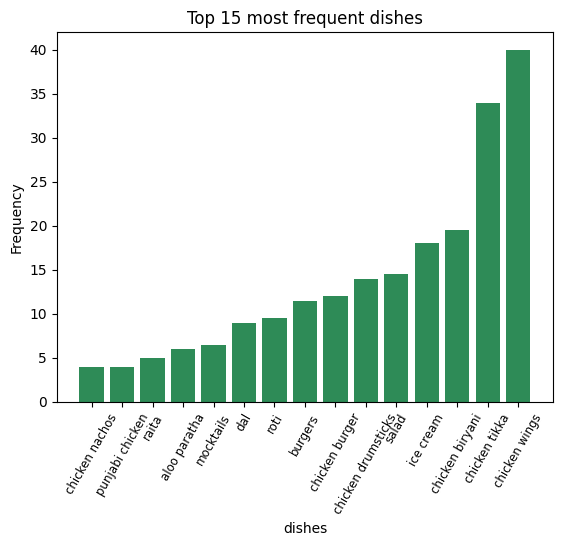

In [79]:
plot_word_freq(
    pd.DataFrame.from_dict({dish:score for dish, score in dish_scores.items() if dish in dishes_list}, orient='index', columns=['frequency']),
    type='dishes')

In [80]:
top5_cluster = dish_labeled.groupby('label').head(15)
drop_dishes = [dish for dish in dish_cooccurrence.index if dish not in top5_cluster.dish.values]
visual_matrix = dish_cooccurrence.drop(drop_dishes, axis=0).drop(drop_dishes, axis=1)

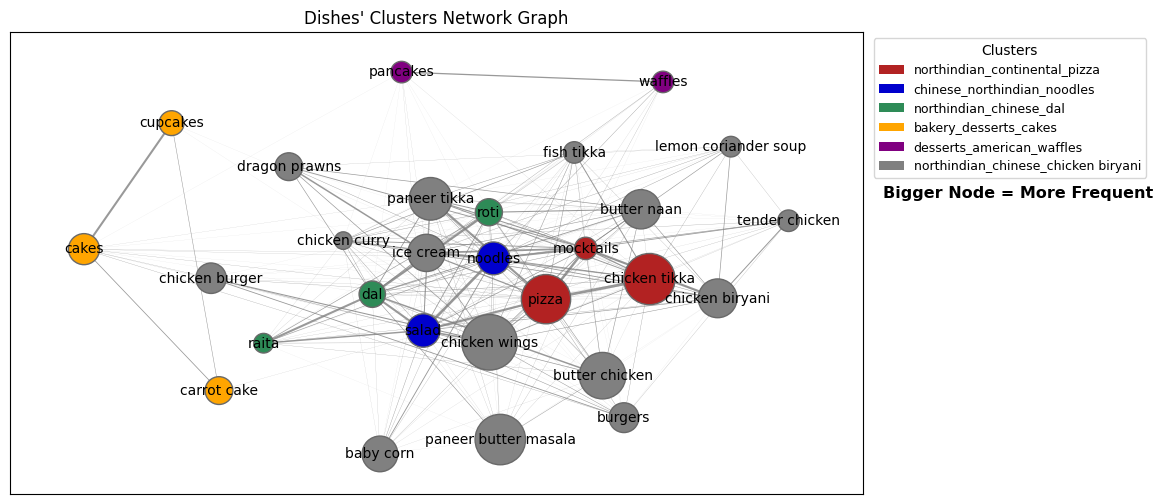

In [260]:
words = top5_cluster.dish.values
clusters = top5_cluster.label.values
freqs = top5_cluster.freq.values
cluster_colors = {0: 'firebrick', 1: 'mediumblue', 2: 'seagreen', 3:'orange', 4:'purple', -1:'gray'}

# Create Graph
G = nx.Graph()
for word, cluster, freq in zip(words,clusters, freqs):
    G.add_node(word, cluster=cluster, color=cluster_colors[cluster], size=freq*40)

# Add edges based on a threshold
threshold = 0.005
for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        if i < j and visual_matrix.iloc[i, j] > threshold:
            G.add_edge(word1, word2, weight=visual_matrix.iloc[i, j])

pos = nx.spring_layout(G, seed=100, k=4)

# Plotting
plt.figure(figsize=(11, 6))
node_colors = [data['color'] for _, data in G.nodes(data=True)]
weights = [data['weight'] for _, _, data in G.edges(data=True)]

node_sizes = nx.get_node_attributes(G, 'size').values()
nx.draw_networkx_nodes(G, pos, node_color=node_colors, edgecolors='dimgrey', node_size=list(node_sizes))
nx.draw_networkx_edges(G, pos, alpha=0.8, edge_color='gray', width=[0.04 * w for w in weights])
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Dishes' Clusters Network Graph")


labels = [f"{cuisines[0][0]}_{cuisines[1][0]}_{dish[0]}" 
                            for cuisines, dish in zip([cluster0_cuisines, cluster1_cuisines, cluster2_cuisines, 
                                                        cluster3_cuisines, cluster4_cuisines, cluster5_cuisines],
                                                    [top5_cluster.loc[top5_cluster.label == 0].iloc[0], top5_cluster.loc[top5_cluster.label == 1].iloc[1], 
                                                    top5_cluster.loc[top5_cluster.label == 2].iloc[0], top5_cluster.loc[top5_cluster.label == 3].iloc[0],
                                                    top5_cluster.loc[top5_cluster.label == 4].iloc[0], top5_cluster.loc[top5_cluster.label == -1].iloc[3]])]

plt.text(1.08, .3, 'Bigger Node = More Frequent', fontsize=11.5, fontweight='bold')

plt.legend(handles=[
    Patch(facecolor=cluster_colors[0]),
    Patch(facecolor=cluster_colors[1]),
    Patch(facecolor=cluster_colors[2]),
    Patch(facecolor=cluster_colors[3]),
    Patch(facecolor=cluster_colors[4]),
    Patch(facecolor=cluster_colors[-1]),], labels=labels, bbox_to_anchor=(.84, 0.5, 0.5, 0.5), fontsize=9, title='Clusters')

plt.show()

The dish clustering solution obtained is not the best, as dishes from the same cluster in the dataset do not co-occur that often. As a result, the majority of dishes were not assigned to any cluster, forming a big cluster. Nonetheless, we could still take away the following insights:
- The purple cluster (desserts_american_waffles) contain two typical american breakfast options: Waffles and Pancakes;
- The red cluster (northindian_continental_pizza) for some reason joins pizza, a typical continental dish; mocktails, a non-alcohol drink option; and chicken tikka, a famous Indian dish;
- The yellow cluster (bakery_desserts_cakes) contains two differents types of cakes: carrot cake, and cupcakes;
- The green cluster (northindian_chinese_dal) joins three typical Indian foods: dal, raita, and roti;
- The blue cluster (chinese_northindian_noodles) has a typical East Asian food - noodles, together with salad;
- Finally, the grey cluster (northindian_chinese_chickenbiryani) contains the dishes that were not assigned to any cluster. The majority of them have chicken, and great part are from India.


In [261]:
cluster_name_mapping = {0 : 'northindian_continental_pizza',
                        1 : 'chinese_northindian_noodles',
                        2 : 'northindian_chinese_dal',
                        3 : 'bakery_desserts_cakes',
                        4 : 'desserts_american_waffles',
                       -1 : 'northindian_chinese_chicken biryani' }

In [262]:
dish_labeled['cluster_name'] = dish_labeled['label'].apply(lambda label: cluster_name_mapping[label])
dish_labeled.head()

dish  label  freq                   cluster_name
0      pizza      0  31.5  northindian_continental_pizza
1  mocktails      0   6.5  northindian_continental_pizza
2      salad      1  14.5    chinese_northindian_noodles
3    noodles      1  14.0    chinese_northindian_noodles
4        dal      2   9.0        northindian_chinese_dal

In [263]:
cluster_colors[4] = 'orange'
cluster_colors[3] = 'gray'
cluster_colors[5] = 'purple'

In [264]:
cluster_colors[4] = 'orange'
cluster_colors[3] = 'gray'
cluster_colors[5] = 'purple'

def plotter_3d_cluster(dataset, distance_matrix, write_html=False, html_name="test.html"):
    
    svd_n3 = TruncatedSVD(n_components=3)
    svd_result = svd_n3.fit_transform(distance_matrix)

    for component in range(3):
        col_name = f"svd_d3_x{component}"
        dataset[col_name] = svd_result[:, component]

    fig = px.scatter_3d(
        dataset,
        x='svd_d3_x0', 
        y='svd_d3_x1', 
        z='svd_d3_x2',
        color="cluster_name", 
        title="3D Plot of the clusters",
        opacity=0.7,
        hover_name="dish", 
        color_discrete_sequence=cluster_colors
    )

    if write_html:
        fig.write_html(html_name)

    fig.show()

plotter_3d_cluster(
    distance_matrix=distance_matrix, 
    dataset=dish_labeled, 
    write_html=False, 
    html_name="dish_clusters_3d_plot.html",
)


Recapping the IR: **What dishes are mentioned together in the reviews? Do they form 
clusters? Can you identify cuisine types based on those clusters?**


**Answer:** Dishes from similar cuisine types tend to be mentioned together in the reviews. With North Indian being the majority cuisine in the dataset, most dishes are from there, which happens to bias the model to some degree. However, clusters with Bakery, Desserts, Chinese and Continental cuisines were still able to be composed, all with specific dishes of that same cuisines.